In [1]:
import os
import numpy as np
from scipy.stats import median_abs_deviation as mad
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core.plot import plot_strips
from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

# overwrite or not
OVERWRITE = False

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
# filter frames with continuum emission in the fibers
target_frames = frames_table.query("(imagetyp=='arc' & ldls & not (argon|neon|xenon|hgne|krypton)) | imagetyp=='object'")
target_frames = target_frames.sort_values("camera").reset_index(drop=True)
target_frames

imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls  \
0     object  sp1  60041     b1  00000679     30.0  False  False  False   
1     object  sp1  60040     b1  00000607    900.0  False  False  False   
2     object  sp1  60039     b1  00000509    120.0  False  False  False   
3     object  sp1  60040     b1  00000641     60.0  False  False  False   
4     object  sp1  60010     b1  00000174    180.0  False  False  False   
..       ...  ...    ...    ...       ...      ...    ...    ...    ...   
676   object  sp3  60039     z3  00000567     15.0  False  False   True   
677   object  sp3  60039     z3  00000509    120.0  False  False  False   
678   object  sp3  60039     z3  00000590    180.0  False  False   True   
679   object  sp3  60039     z3  00000504    120.0  False  False  False   
680   object  sp3  60039     z3  00000503      5.0  False  False  False   

      hgne  xenon  krypton                                               path  
0    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
1    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
2    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
3    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
4    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
..     ...    ...      ...                                                ...  
676  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
677  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
678  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
679  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
680  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  

[681 rows x 13 columns]

MJD:   0%|          | 0/5 [00:00<?, ?mjd/s]

camera:   0%|          | 0/3 [00:00<?, ?camera/s]

frame:   0%|          | 0/30 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4   cnt_std1   cnt_std2   cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                        
2023-03-07 00:28:26.648  sdR-s-b1-00000080       80     5.0  2707.290039  2707.290039       2680.0       2690.0   1.943205   2.074621   1.973921   2.110405      3.0      3.0      2.8      2.8
2023-03-07 04:34:48.217  sdR-s-b1-00000153      153    60.0  2707.290039  2707.290039       2680.0       2690.0   1.952386   2.090373    1.97182   2.110627      3.0      3.0      2.8      2.8
2023-03-07 04:41:25.093  sdR-s-b1-00000154      154   180.0  2707.290039  2707.290039  2677.320068       2690.0   1.954522   2.071479   1.972672   2.108768      3.0      3.0      2.8      2.8
2023-03-07 04:49:53.624  sdR-s-b1-000001

frame:   0%|          | 0/30 [00:00<?, ?frame/s]

                                     frame exposure exptime cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                
2023-03-07 00:28:26.648  sdR-s-r1-00000080       80     5.0   2744.5  2787.209961  2655.880127  2759.179932      8.592637       9.43053      9.296196      9.906432      3.2      3.3      3.0      3.1
2023-03-07 04:34:48.217  sdR-s-r1-00000153      153    60.0  2719.75   2756.52002  2626.400146  2723.560059      6.792022      6.775489      6.549557      7.002286      3.2      3.3      3.0      3.1
2023-03-07 04:41:25.093  sdR-s-r1-00000154      154   180.0  2719.75   2756.52002  2626.400146  2723.560059      6.799863      6.760363      6.536672      7.010421      3.2      3.3      3.0      3.1


frame:   0%|          | 0/30 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                    
2023-03-07 00:28:26.648  sdR-s-z1-00000080       80     5.0  2746.199951  2631.450195  2904.450195  2810.580078      3.227383      3.152905      3.445626      3.399663      3.6      3.6      3.4      3.6
2023-03-07 04:34:48.217  sdR-s-z1-00000153      153    60.0  2746.199951  2631.450195  2904.450195  2810.580078      3.151243      3.094912      3.476253      3.387665      3.6      3.6      3.4      3.6
2023-03-07 04:41:25.093  sdR-s-z1-00000154      154   180.0  2746.199951  2631.450195  2904.450195  2810.580078      3.173504      3.076595      3.725301      3.402498      3.6      3.

camera:   0%|          | 0/3 [00:00<?, ?camera/s]

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3 cnt_med4  cnt_std1  cnt_std2  cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                
2023-03-08 00:00:13.297  sdR-s-b1-00000203      203   300.0  2707.290039  2707.290039       2680.0   2690.0  1.934225  2.070168  1.979488  2.122664      3.0      3.0      2.8      2.8
2023-03-08 00:12:55.338  sdR-s-b1-00000204      204   600.0  2707.290039  2707.290039       2680.0   2690.0  1.937958  2.068345  1.971775  2.101466      3.0      3.0      2.8      2.8
2023-03-08 00:32:51.311  sdR-s-b1-00000205      205     5.0  2707.290039  2707.290039       2680.0   2690.0  1.937667  2.074165  1.979278  2.101593      3.0      3.0      2.8      2.8
2023-03-08 00:35:42.078  sdR-s-b1-00000206      206     2.0  2707.290039  2707.2

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

                                     frame exposure exptime cnt_med1     cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2    cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                         
2023-03-08 00:00:13.297  sdR-s-r1-00000203      203   300.0   2777.5  2820.689941  2685.360107  2786.580078  2087.674072  1999.765991    7.565618   7.809999      3.2      3.3      3.0      3.1
2023-03-08 00:12:55.338  sdR-s-r1-00000204      204   600.0  2774.75  2817.899902  2682.680176  2786.580078  3052.524902  2898.342041  658.202209  922.84552      3.2      3.3      3.0      3.1
2023-03-08 00:32:51.311  sdR-s-r1-00000205      205     5.0   2777.5  2817.899902  2685.360107  2786.580078     6.652677     7.660772    7.450182    7.69421      3.2      3.3      3.0      3.1
2023-03-08 00:35:42.078  sdR-s-r1-0

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2     cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                              
2023-03-08 00:00:13.297  sdR-s-z1-00000203      203   300.0  2746.199951  2634.100098  2904.450195  2810.580078  1874.723877  2489.993652    40.996704    3.44397      3.6      3.6      3.4      3.6
2023-03-08 00:12:55.338  sdR-s-z1-00000204      204   600.0  2746.199951  2634.100098  2904.450195  2810.580078  2793.678467  3654.853516    29.539717   3.450265      3.6      3.6      3.4      3.6
2023-03-08 00:32:51.311  sdR-s-z1-00000205      205     5.0  2746.199951  2634.100098  2904.450195  2810.580078     3.474823     3.413308     3.504496   3.432108      3.6      3.6      3.4      3.6
2023-03-08

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                    
2023-04-05 01:19:22.054  sdR-s-b1-00000496      496     5.0   2677.47998  2699.160156  2666.600098  2665.790039      3.111703       3.19667      3.571877      3.606674      3.0      3.0      2.8      2.8
2023-04-05 02:11:26.768  sdR-s-b1-00000497      497    30.0  2680.189941  2699.160156  2669.280029   2668.47998  11559.323242  11521.486328  11409.263672  13754.704102      3.0      3.0      2.8      2.8
2023-04-05 02:13:16.746  sdR-s-b1-00000498      498     5.0   2677.47998  2699.160156  2669.280029  2665.790039   4297.454102    4384.79541   3992.713623   5015.098145      3.0      3.

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3 cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                
2023-04-05 01:18:00.703  sdR-s-b3-00000495      495     5.0  2432.850098       2460.0   2506.73999   2525.0      2.815256      2.820879      3.065967      3.163186      3.0      3.0      2.8      2.8
2023-04-05 01:19:22.053  sdR-s-b3-00000496      496     5.0  2432.850098       2460.0   2506.73999   2525.0      2.836105      2.861721      3.021118      3.177455      3.0      3.0      2.8      2.8
2023-04-05 02:11:26.768  sdR-s-b3-00000497      497    30.0  2432.850098  2462.459961  2509.199951   2527.5  13115.536133  14654.282227  12683.892578  17525.087891      3.0      3.0      2.8      2.8


frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1     cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                               
2023-04-05 01:19:22.054  sdR-s-r1-00000496      496     5.0  2796.75  2845.800049   2698.76001  2792.060059     13.982206    15.708059     14.752665     12.557855      3.2      3.3      3.0      3.1
2023-04-05 02:11:26.768  sdR-s-r1-00000497      497    30.0   2799.5  2848.589844  2701.440186  2794.800049  14543.331055  13985.84668  13647.744141  17087.185547      3.2      3.3      3.0      3.1
2023-04-05 02:13:16.746  sdR-s-r1-00000498      498     5.0  2796.75  2848.589844   2698.76001  2792.060059   6171.037598  5945.573242    5564.03125   6887.948242      3.2      3.3      3.0      3.1
2023-

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                    
2023-04-05 01:18:00.703  sdR-s-r3-00000495      495     5.0  2682.600098  2698.080078  2713.600098  2769.620117      3.154279      3.084145      3.453705      3.525611      3.2      3.3      3.0      3.1
2023-04-05 01:19:22.053  sdR-s-r3-00000496      496     5.0  2682.600098  2698.080078  2710.950195  2769.620117      3.125435      3.081861      3.471787      3.443099      3.2      3.3      3.0      3.1
2023-04-05 02:11:26.768  sdR-s-r3-00000497      497    30.0  2685.230225  2698.080078  2713.600098  2772.330078  13562.128906  13500.521484  12108.032227  13938.849609      3.2      3.

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                    
2023-04-05 01:19:22.054  sdR-s-z1-00000496      496     5.0  2743.439941  2631.450195  2904.450195   2805.02002      3.122332      3.029403      3.466085      3.392089      3.6      3.6      3.4      3.6
2023-04-05 02:11:26.768  sdR-s-z1-00000497      497    30.0  2746.199951  2634.100098  2910.230225  2807.800049  12392.205078  16001.228516  14081.893555  18311.826172      3.6      3.6      3.4      3.6
2023-04-05 02:13:16.746  sdR-s-z1-00000498      498     5.0  2746.199951  2631.450195  2907.340088  2807.800049   6473.383301   8521.657227   6410.665039   8280.585938      3.6      3.

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4      cnt_std1      cnt_std2      cnt_std3      cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                    
2023-04-05 01:18:00.703  sdR-s-z3-00000495      495     5.0  2615.599854  2673.850098  2593.129883  2739.040039      2.891608      2.971065      3.100426      3.534714      3.6      3.6      3.4      3.6
2023-04-05 01:19:22.053  sdR-s-z3-00000496      496     5.0  2615.599854  2673.850098  2590.559814  2739.040039      2.883236      2.948405      3.067485      3.510755      3.6      3.6      3.4      3.6
2023-04-05 02:11:26.768  sdR-s-z3-00000497      497    30.0  2618.199951       2676.5   2598.27002   2744.47998  17470.835938  17711.707031  12413.087891  17662.755859      3.6      3.

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime    cnt_med1     cnt_med2     cnt_med3     cnt_med4  cnt_std1  cnt_std2  cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                   
2023-04-06 00:06:03.999  sdR-s-b1-00000603      603    30.0  2677.47998  2699.160156  2666.600098  2665.790039  3.087961  3.165879  3.523328  3.578742      3.0      3.0      2.8      2.8
2023-04-06 00:08:59.336  sdR-s-b1-00000604      604    30.0  2677.47998  2699.160156  2666.600098  2665.790039  3.112972  3.173884  3.544337  3.561258      3.0      3.0      2.8      2.8
2023-04-06 00:15:05.859  sdR-s-b1-00000605      605    30.0  2677.47998  2699.160156  2666.600098  2665.790039  3.101258  3.179041  3.550242  3.555893      3.0      3.0      2.8      2.8
2023-04-06 00:52:56.321  sdR-s-b1-00000606      606   900.0  2677

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3 cnt_med4   cnt_std1   cnt_std2  cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                   
2023-04-06 01:22:24.859  sdR-s-b2-00000608      608    10.0  2452.449951  2457.540039  2472.300049   2507.5  10.649172  11.428467  10.36538  11.398088      3.0      3.0      2.8      2.8
2023-04-06 03:30:25.114  sdR-s-b2-00000612      612    10.0  2454.900146  2457.540039  2472.300049   2505.0   8.848218   9.709085  8.602196  10.037923      3.0      3.0      2.8      2.8
2023-04-06 03:31:34.837  sdR-s-b2-00000613      613    10.0  2454.900146  2457.540039  2472.300049   2505.0   9.418803  10.305907  9.168437  10.575008      3.0      3.0      2.8      2.8
2023-04-06 03:37:17.124  sdR-s-b2-00000614      614    10.0  2454

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime cnt_med1     cnt_med2     cnt_med3     cnt_med4   cnt_std1   cnt_std2   cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                    
2023-04-06 00:06:03.999  sdR-s-r1-00000603      603    30.0  2796.75  2845.800049   2698.76001  2789.320068  13.844843  15.388943  14.582098  12.144303      3.2      3.3      3.0      3.1
2023-04-06 00:08:59.336  sdR-s-r1-00000604      604    30.0  2796.75  2845.800049   2698.76001  2789.320068  13.722456  15.163099  14.536255  11.942346      3.2      3.3      3.0      3.1
2023-04-06 00:15:05.859  sdR-s-r1-00000605      605    30.0  2796.75  2845.800049   2698.76001  2792.060059  13.555049  15.308273  14.295255  12.041753      3.2      3.3      3.0      3.1
2023-04-06 00:52:56.321  sdR-s-r1-00000606      606   900.0 

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4  cnt_std1  cnt_std2  cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                    
2023-04-06 01:22:24.859  sdR-s-r2-00000608      608    10.0  2672.080078  2647.920166  2634.100098  2696.449951  2.987293  2.974973  3.367608  3.304313      3.2      3.3      3.0      3.1
2023-04-06 03:30:25.114  sdR-s-r2-00000612      612    10.0  2672.080078  2647.920166  2634.100098  2699.160156  2.989151  2.978889  3.398458  3.315457      3.2      3.3      3.0      3.1
2023-04-06 03:31:34.837  sdR-s-r2-00000613      613    10.0  2672.080078  2647.920166  2634.100098  2699.160156  3.020435  2.986441  3.369809   3.32538      3.2      3.3      3.0      3.1
2023-04-06 03:37:17.124  sdR-s-r2-00000614      614    10.0 

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3    cnt_med4  cnt_std1  cnt_std2   cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                    
2023-04-06 00:06:03.999  sdR-s-z1-00000603      603    30.0  2743.439941  2631.450195  2904.450195  2805.02002  3.120955  3.029778   3.459282  3.393568      3.6      3.6      3.4      3.6
2023-04-06 00:08:59.336  sdR-s-z1-00000604      604    30.0  2743.439941  2631.450195  2904.450195  2805.02002  3.128079  3.030557   3.436672  3.378822      3.6      3.6      3.4      3.6
2023-04-06 00:15:05.859  sdR-s-z1-00000605      605    30.0  2743.439941  2631.450195  2904.450195  2805.02002  3.108896  3.035277   3.447356  3.384666      3.6      3.6      3.4      3.6
2023-04-06 00:52:56.321  sdR-s-z1-00000606      606   900.0 

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4  cnt_std1  cnt_std2  cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                    
2023-04-06 01:22:24.859  sdR-s-z2-00000608      608    10.0  2605.199951  2634.100098  2580.280029  2730.880127  3.157572  3.295442  3.110111  3.406314      3.6      3.6      3.4      3.6
2023-04-06 03:30:25.114  sdR-s-z2-00000612      612    10.0  2607.799805      2636.75  2582.849854  2733.600098  3.146705  3.317173  3.138887  3.416128      3.6      3.6      3.4      3.6
2023-04-06 03:31:34.837  sdR-s-z2-00000613      613    10.0  2607.799805      2636.75  2582.849854  2733.600098  3.161074  3.312623  3.165169  3.422533      3.6      3.6      3.4      3.6
2023-04-06 03:37:17.124  sdR-s-z2-00000614      614    10.0 

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

                                     frame exposure exptime    cnt_med1     cnt_med2     cnt_med3     cnt_med4  cnt_std1  cnt_std2  cnt_std3  cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                   
2023-04-07 00:15:21.871  sdR-s-b1-00000672      672   900.0  2677.47998  2699.160156  2666.600098  2665.790039  3.087136  3.169509  3.537645  3.580391      3.0      3.0      2.8      2.8
2023-04-07 00:32:24.463  sdR-s-b1-00000673      673   900.0  2677.47998  2696.449951  2666.600098  2665.790039  3.089691  3.176233  3.558095  3.581675      3.0      3.0      2.8      2.8
2023-04-07 00:49:33.418  sdR-s-b1-00000674      674   900.0  2677.47998  2699.160156  2666.600098  2665.790039  3.110711  3.145627  3.560553  3.572352      3.0      3.0      2.8      2.8
2023-04-07 01:06:16.447  sdR-s-b1-00000675      675   900.0  2677

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3 cnt_med4  cnt_std1   cnt_std2  cnt_std3   cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                  
2023-04-07 00:15:21.871  sdR-s-b2-00000672      672   900.0  2454.900146  2457.540039   2474.76001   2505.0  7.413895   8.199777  7.186701   8.464054      3.0      3.0      2.8      2.8
2023-04-07 00:32:24.463  sdR-s-b2-00000673      673   900.0  2454.900146  2457.540039   2474.76001   2505.0   7.59612   8.388451  7.337876   8.629427      3.0      3.0      2.8      2.8
2023-04-07 00:49:33.417  sdR-s-b2-00000674      674   900.0  2454.900146  2457.540039   2474.76001   2505.0  7.835211    8.64864  7.584414   8.895231      3.0      3.0      2.8      2.8
2023-04-07 01:06:16.447  sdR-s-b2-00000675      675   900.0  2454.9001

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

[WARNING]: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`. (RuntimeWarning)
                                     frame exposure exptime cnt_med1     cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2     cnt_std3     cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                            
2023-04-07 00:15:21.871  sdR-s-r1-00000672      672   900.0  2736.25  2770.469971  2637.120117   2737.26001     5.091189     4.906696      4.56548     5.336568      3.2      3.3      3.0      3.1
2023-04-07 00:32:24.463  sdR-s-r1-00000673      673   900.0   2733.5  2767.679932  2639

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2    cnt_std3     cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                               
2023-04-07 00:15:21.871  sdR-s-r2-00000672      672   900.0  2672.080078  2647.920166  2634.100098  2696.449951     3.004639     2.954426     3.35838     3.327788      3.2      3.3      3.0      3.1
2023-04-07 00:32:24.463  sdR-s-r2-00000673      673   900.0  2672.080078  2647.920166  2634.100098  2696.449951     2.987294     2.968299    3.381665     3.313426      3.2      3.3      3.0      3.1
2023-04-07 00:49:33.417  sdR-s-r2-00000674      674   900.0  2672.080078  2647.920166  2634.100098  2696.449951     2.989116     2.972129    3.374421     3.303366      3.2      3.3      3.0      3.1
2023-

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1     cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2     cnt_std3     cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                                
2023-04-07 00:15:21.871  sdR-s-z1-00000672      672   900.0  2743.439941  2631.450195  2904.450195   2805.02002     3.103197     3.030073     6.073953     3.388261      3.6      3.6      3.4      3.6
2023-04-07 00:32:24.463  sdR-s-z1-00000673      673   900.0  2743.439941  2631.450195  2904.450195   2805.02002      3.11613     3.041832     6.090583      3.37748      3.6      3.6      3.4      3.6
2023-04-07 00:49:33.418  sdR-s-z1-00000674      674   900.0  2743.439941  2631.450195  2904.450195   2805.02002     3.108726     3.024292     6.248088     3.407222      3.6      3.6      3.4      3.6


frame:   0%|          | 0/28 [00:00<?, ?frame/s]

                                     frame exposure exptime     cnt_med1 cnt_med2     cnt_med3     cnt_med4     cnt_std1     cnt_std2     cnt_std3     cnt_std4 rdnoise1 rdnoise2 rdnoise3 rdnoise4
obstime                                                                                                                                                                                            
2023-04-07 00:15:21.871  sdR-s-z2-00000672      672   900.0  2605.199951  2636.75  2580.280029  2733.600098     3.169418     3.321147     3.188273     3.425198      3.6      3.6      3.4      3.6
2023-04-07 00:32:24.463  sdR-s-z2-00000673      673   900.0  2605.199951  2636.75  2580.280029  2733.600098     3.166041     3.323345     3.201729     3.438652      3.6      3.6      3.4      3.6
2023-04-07 00:49:33.417  sdR-s-z2-00000674      674   900.0  2605.199951  2636.75  2580.280029  2733.600098     3.155693     3.299652     3.203466      3.42353      3.6      3.6      3.4      3.6
2023-04-07 01:06:16.

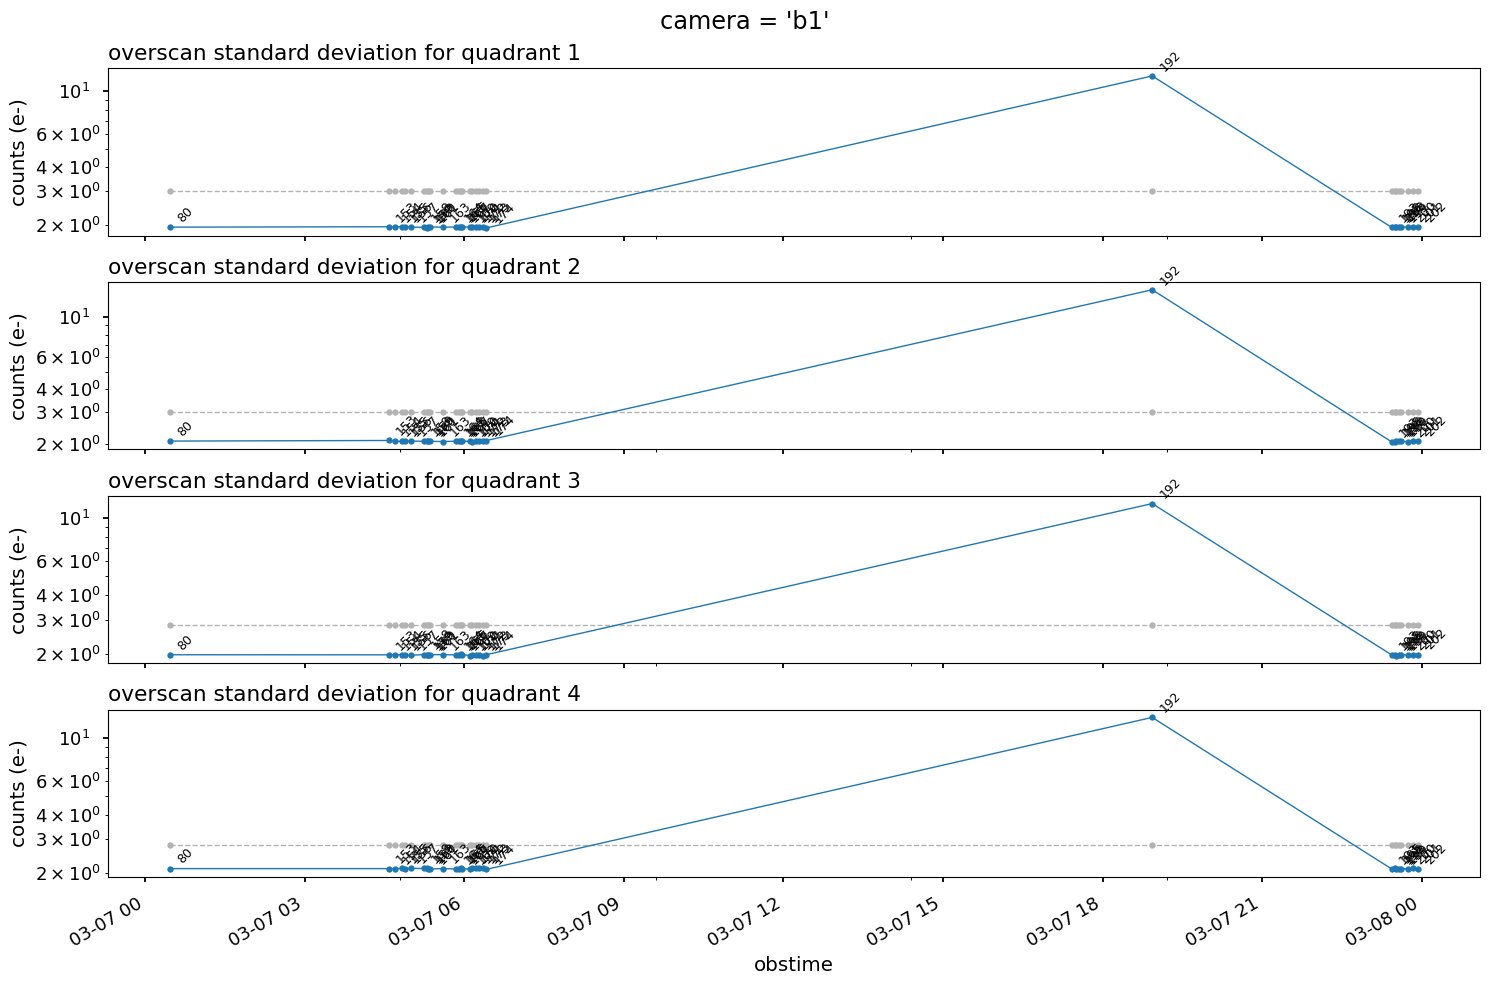

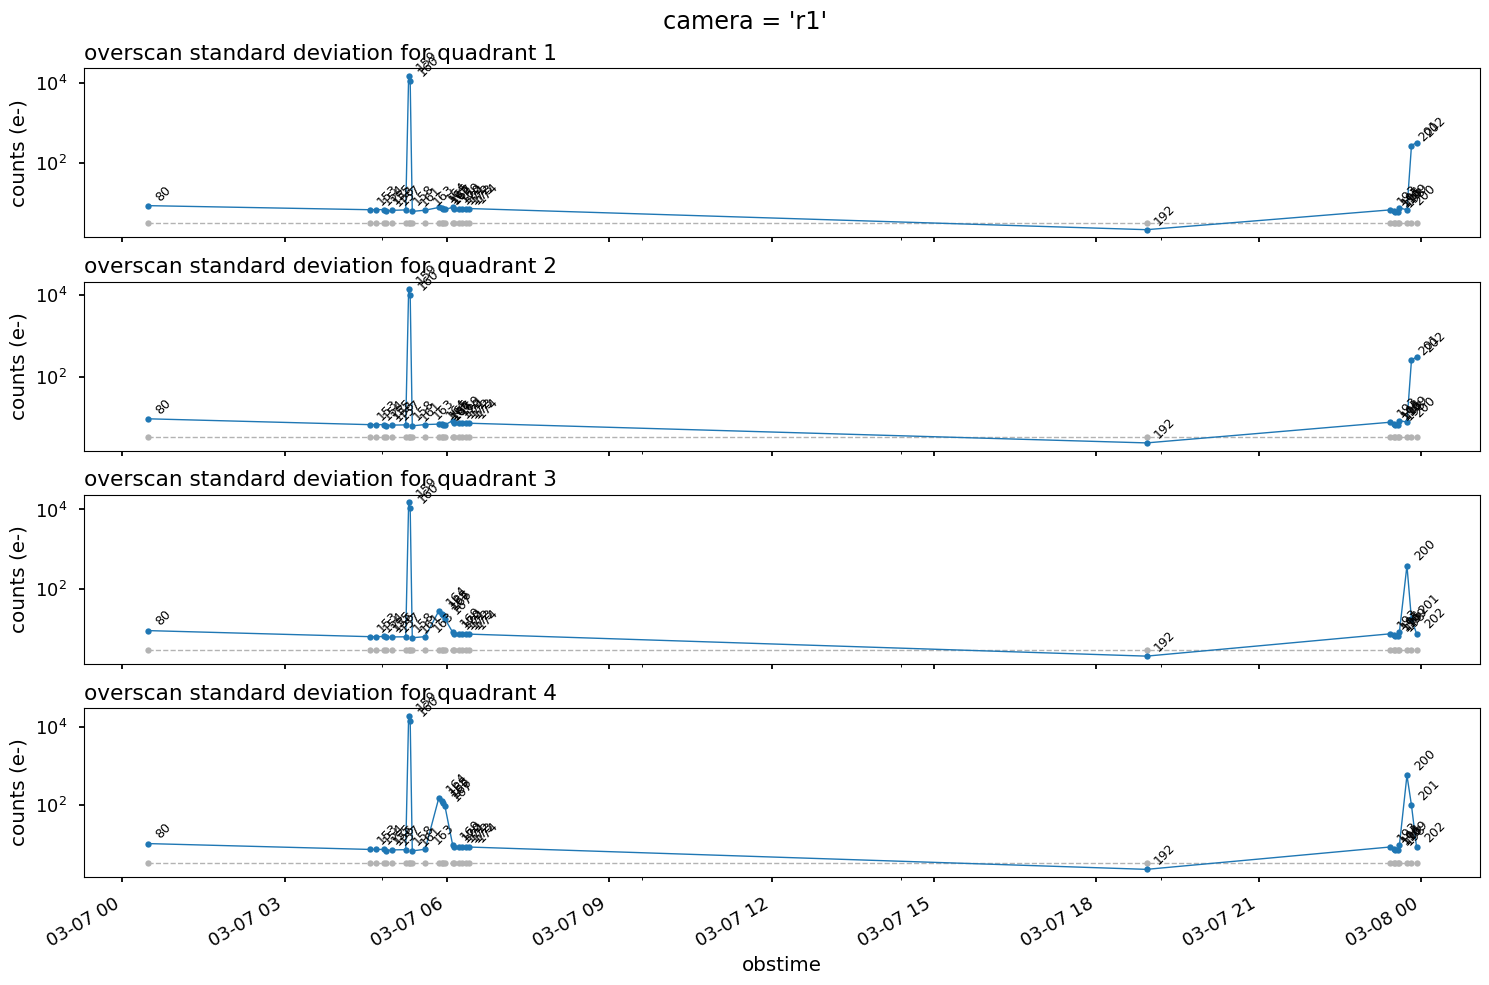

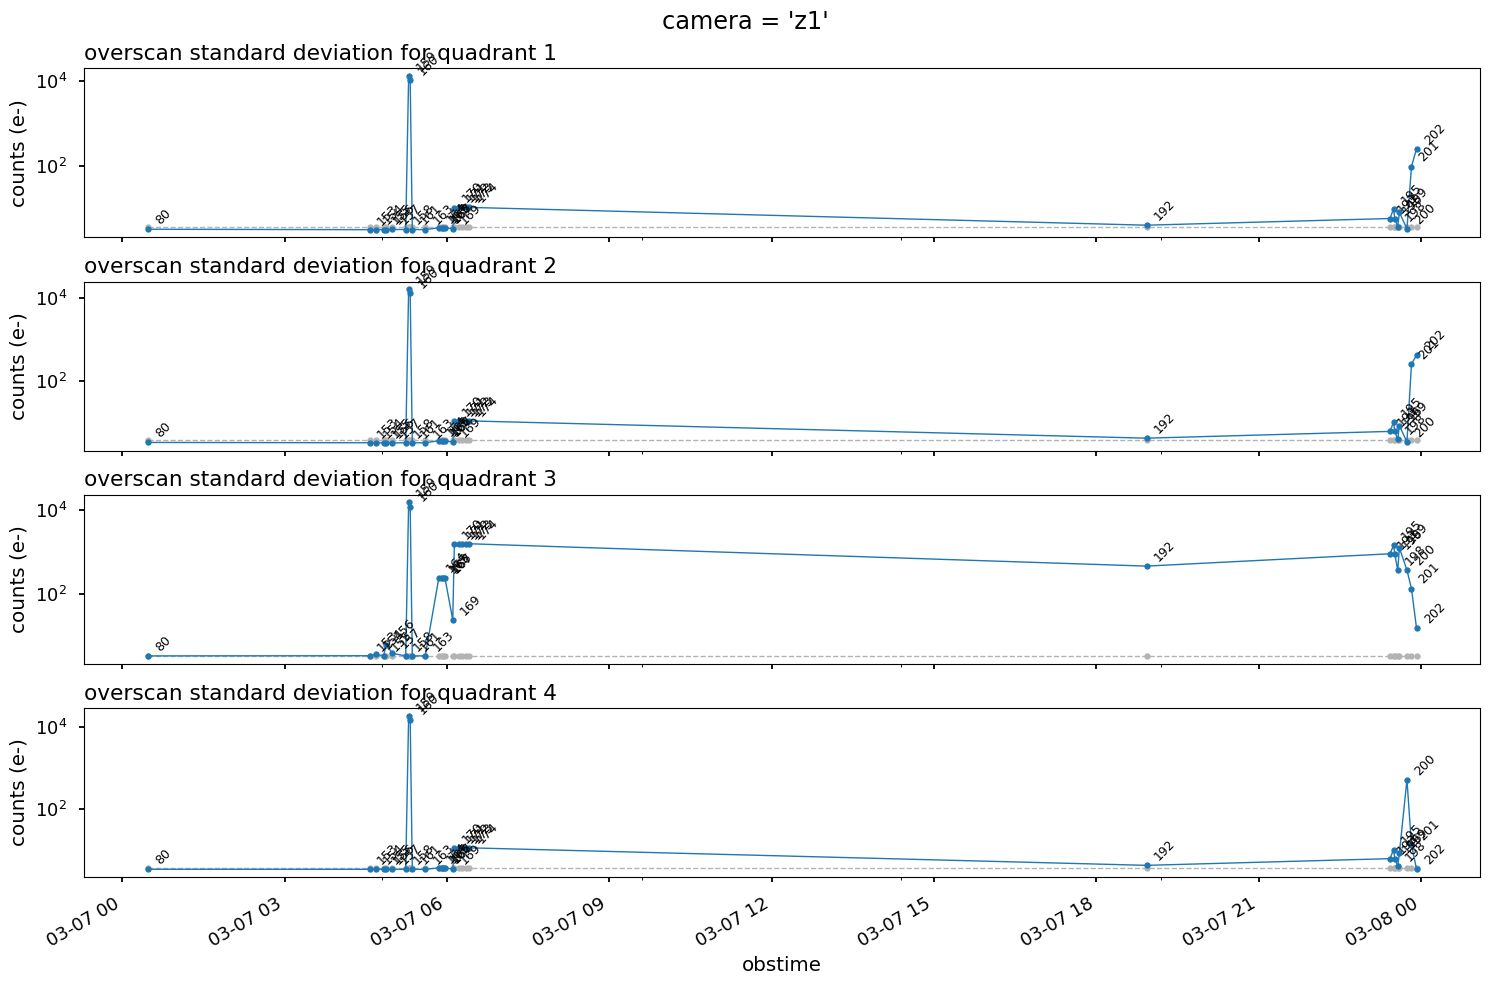

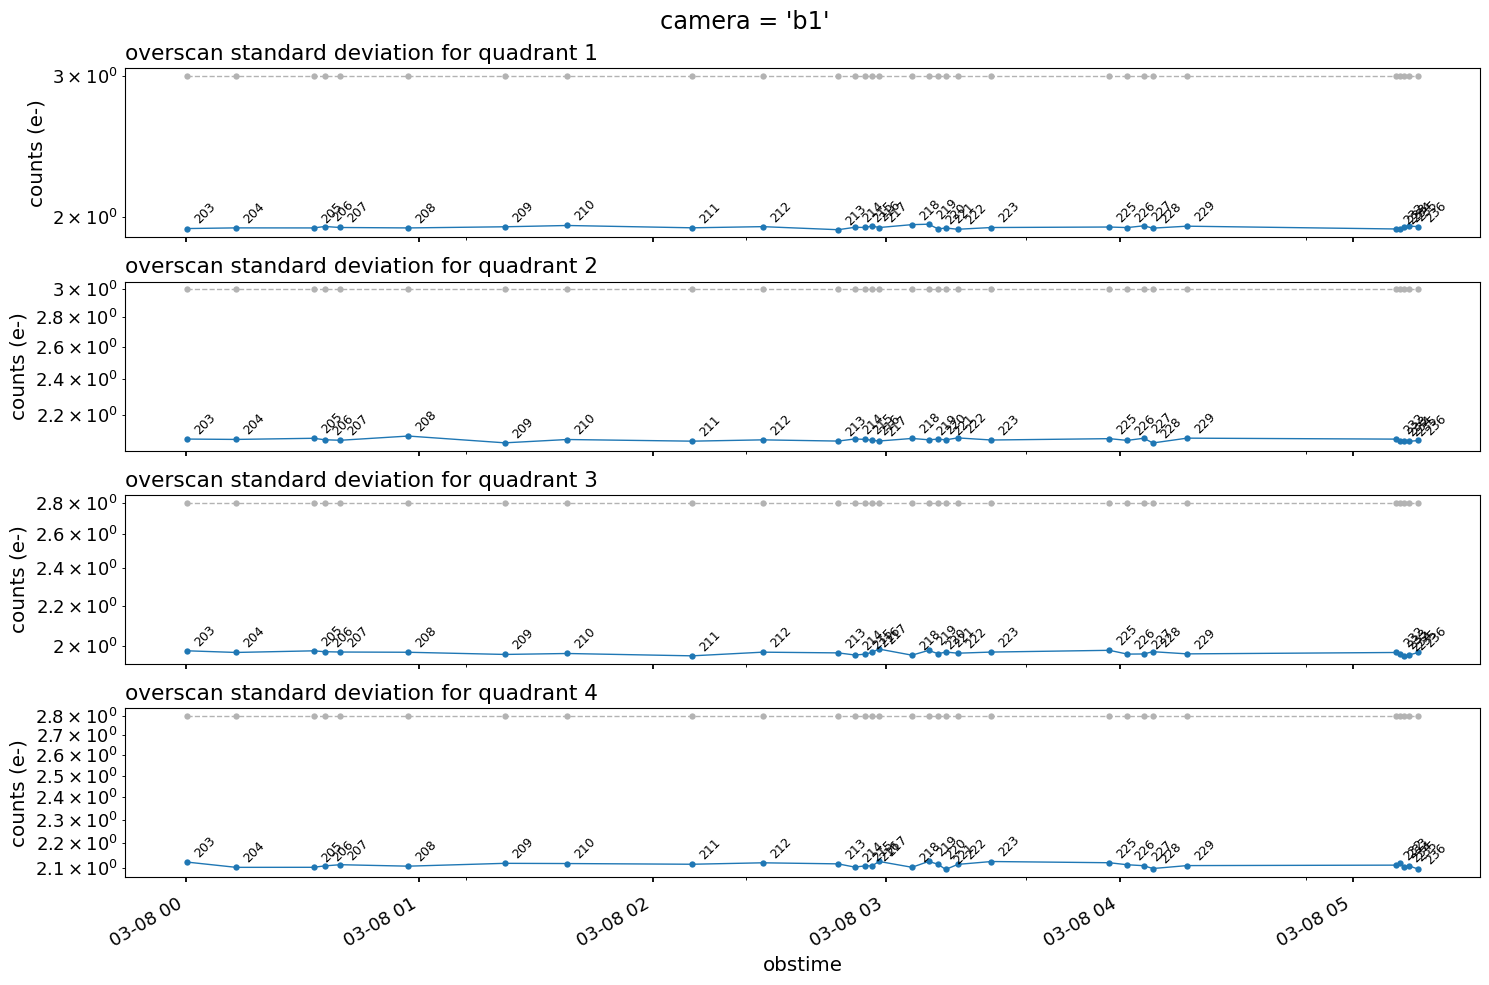

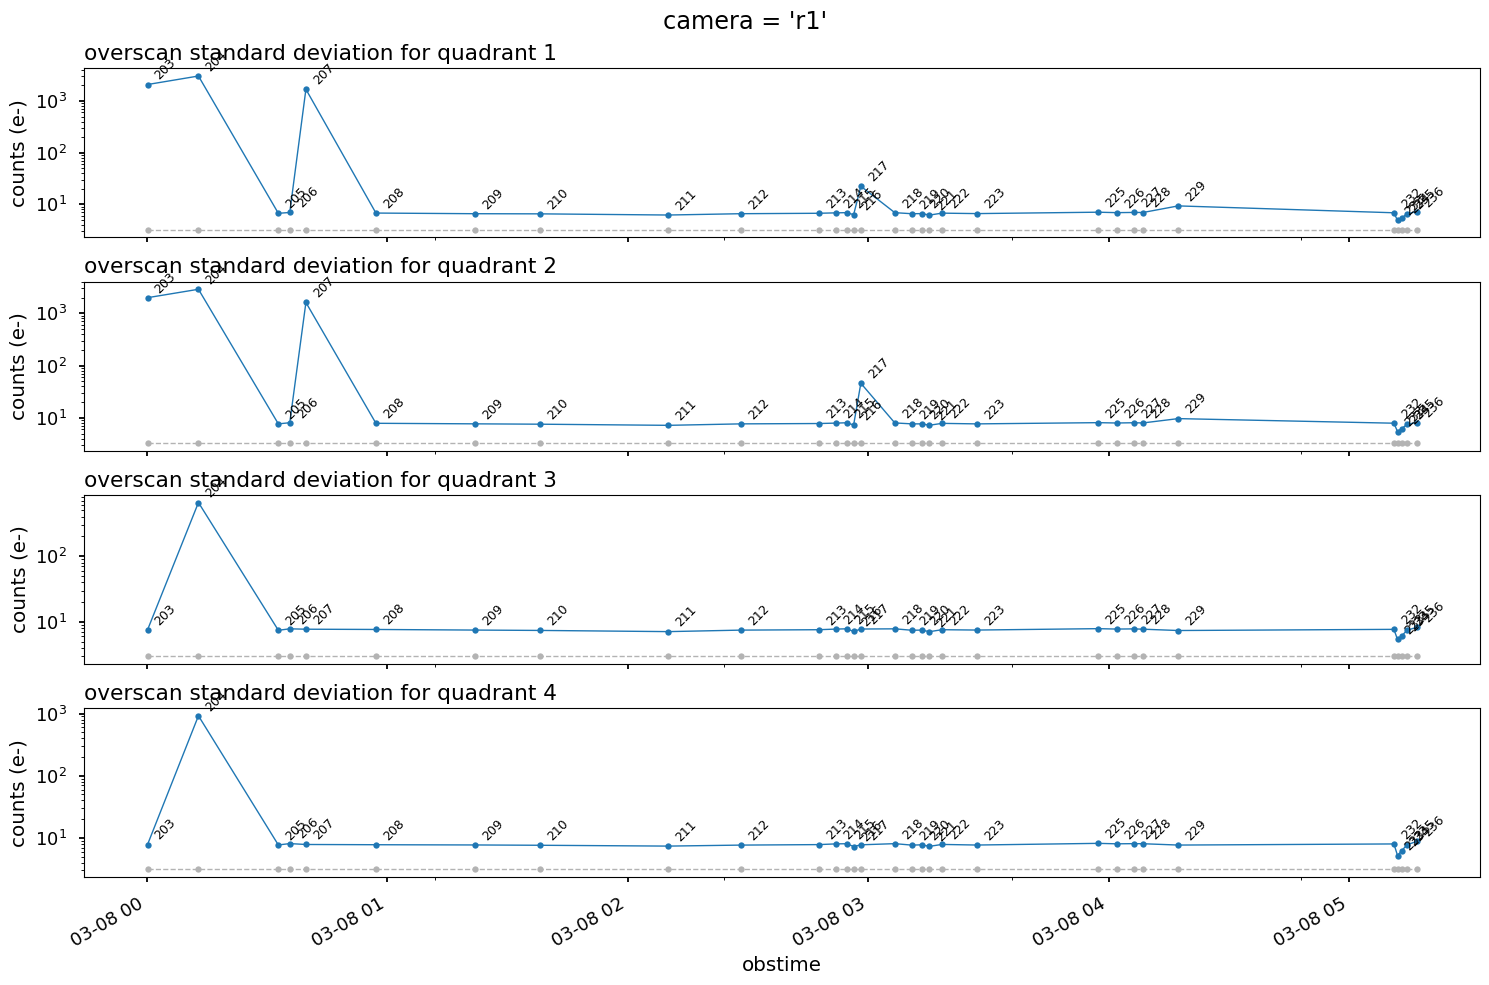

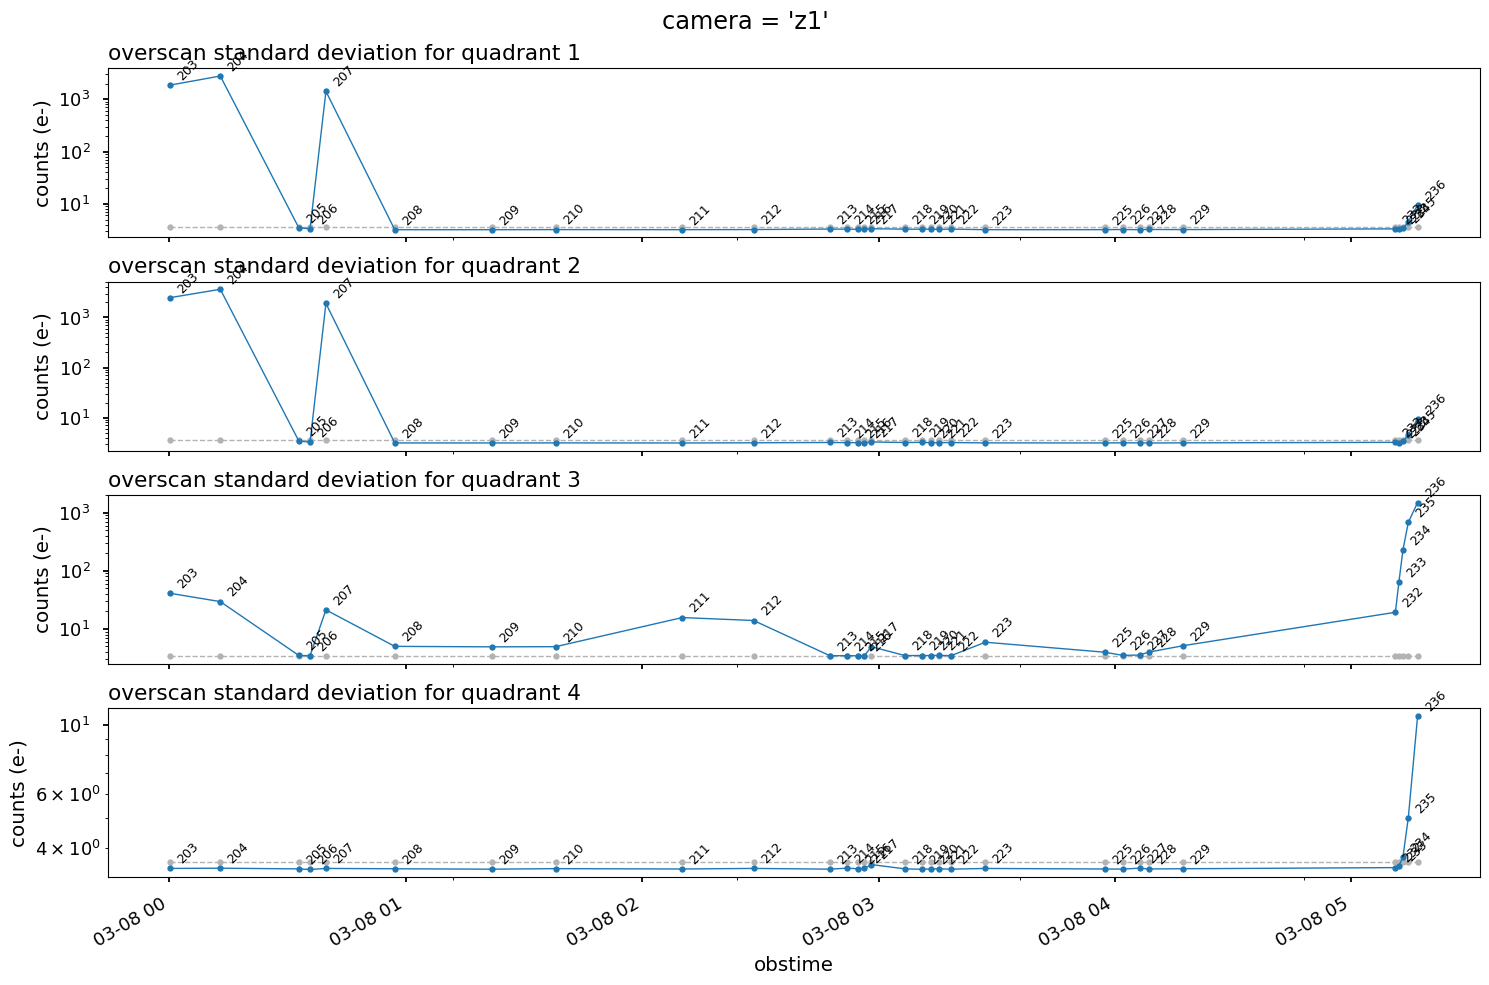

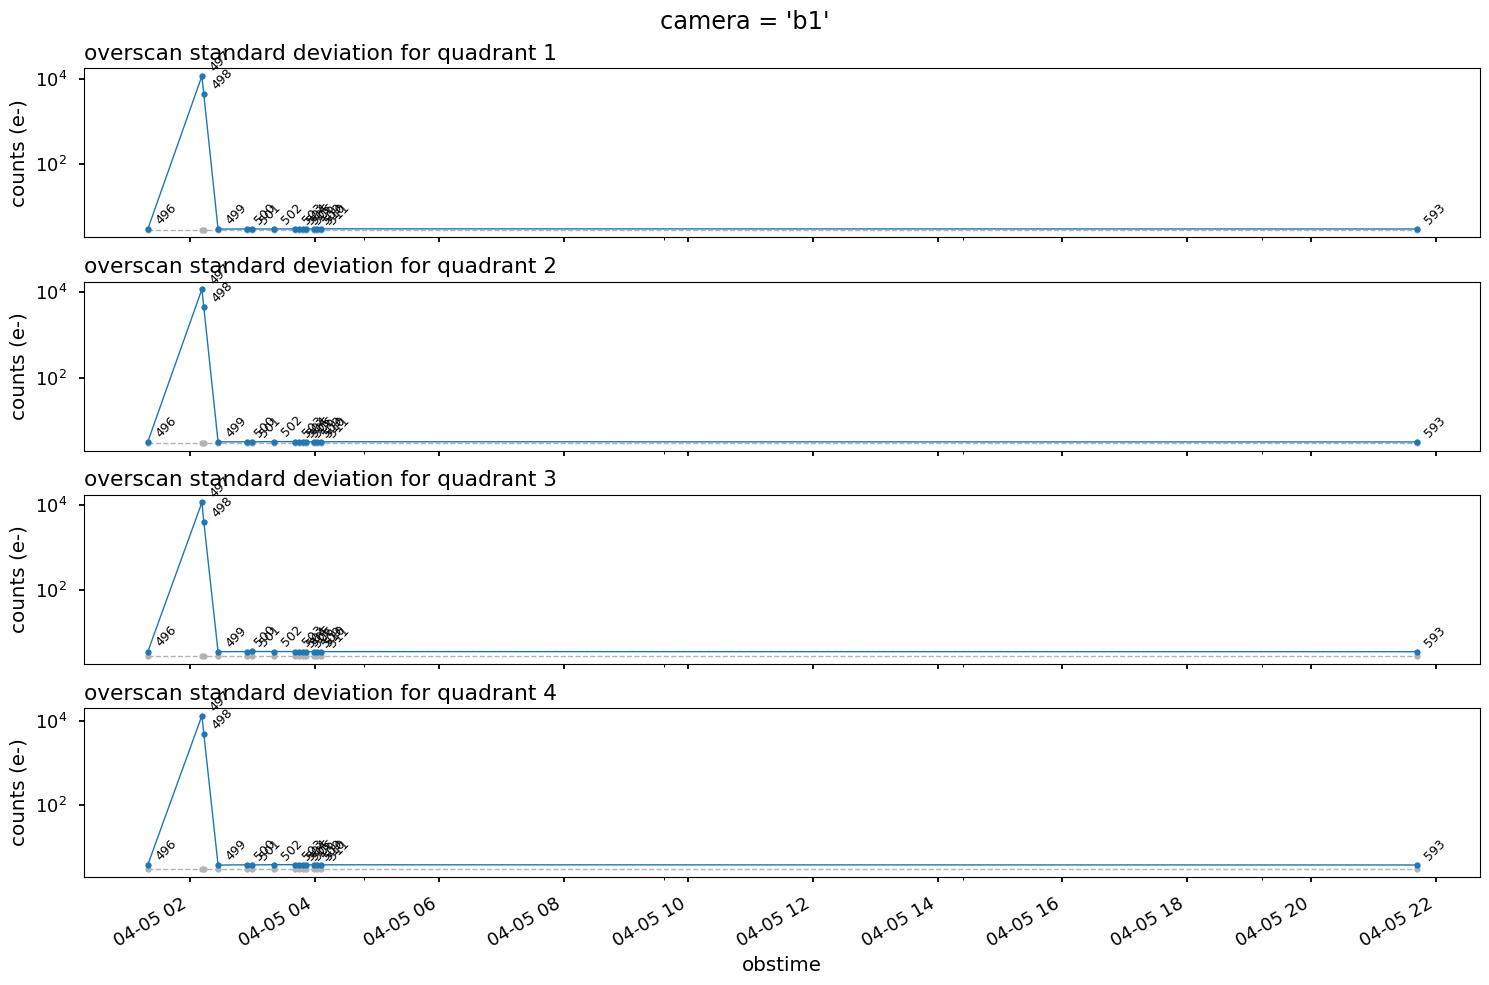

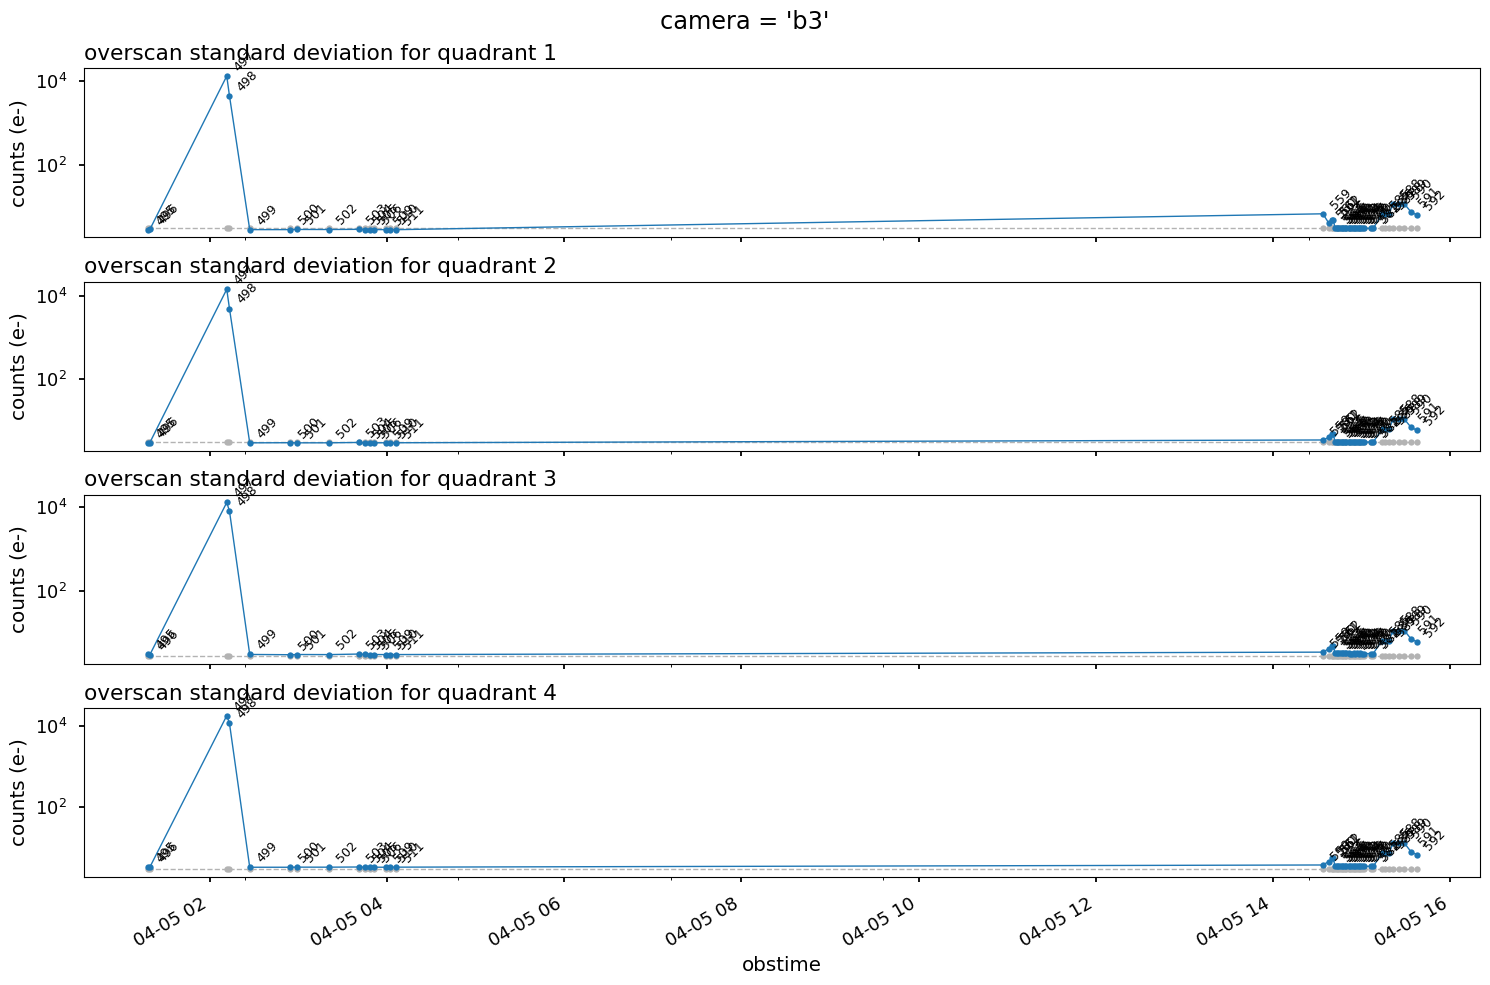

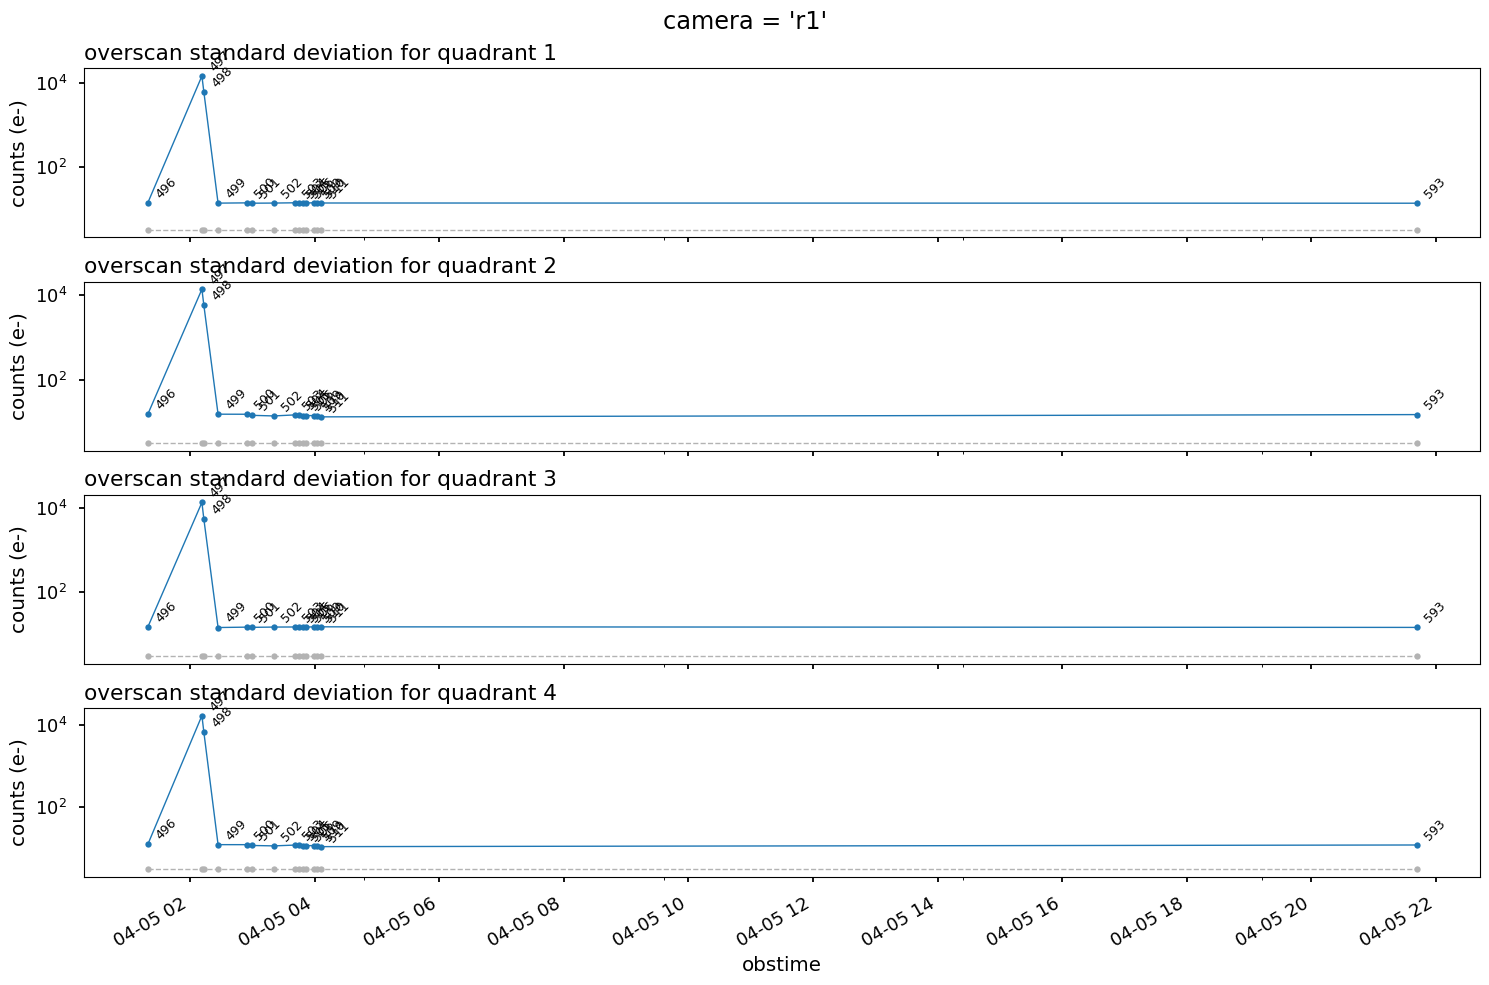

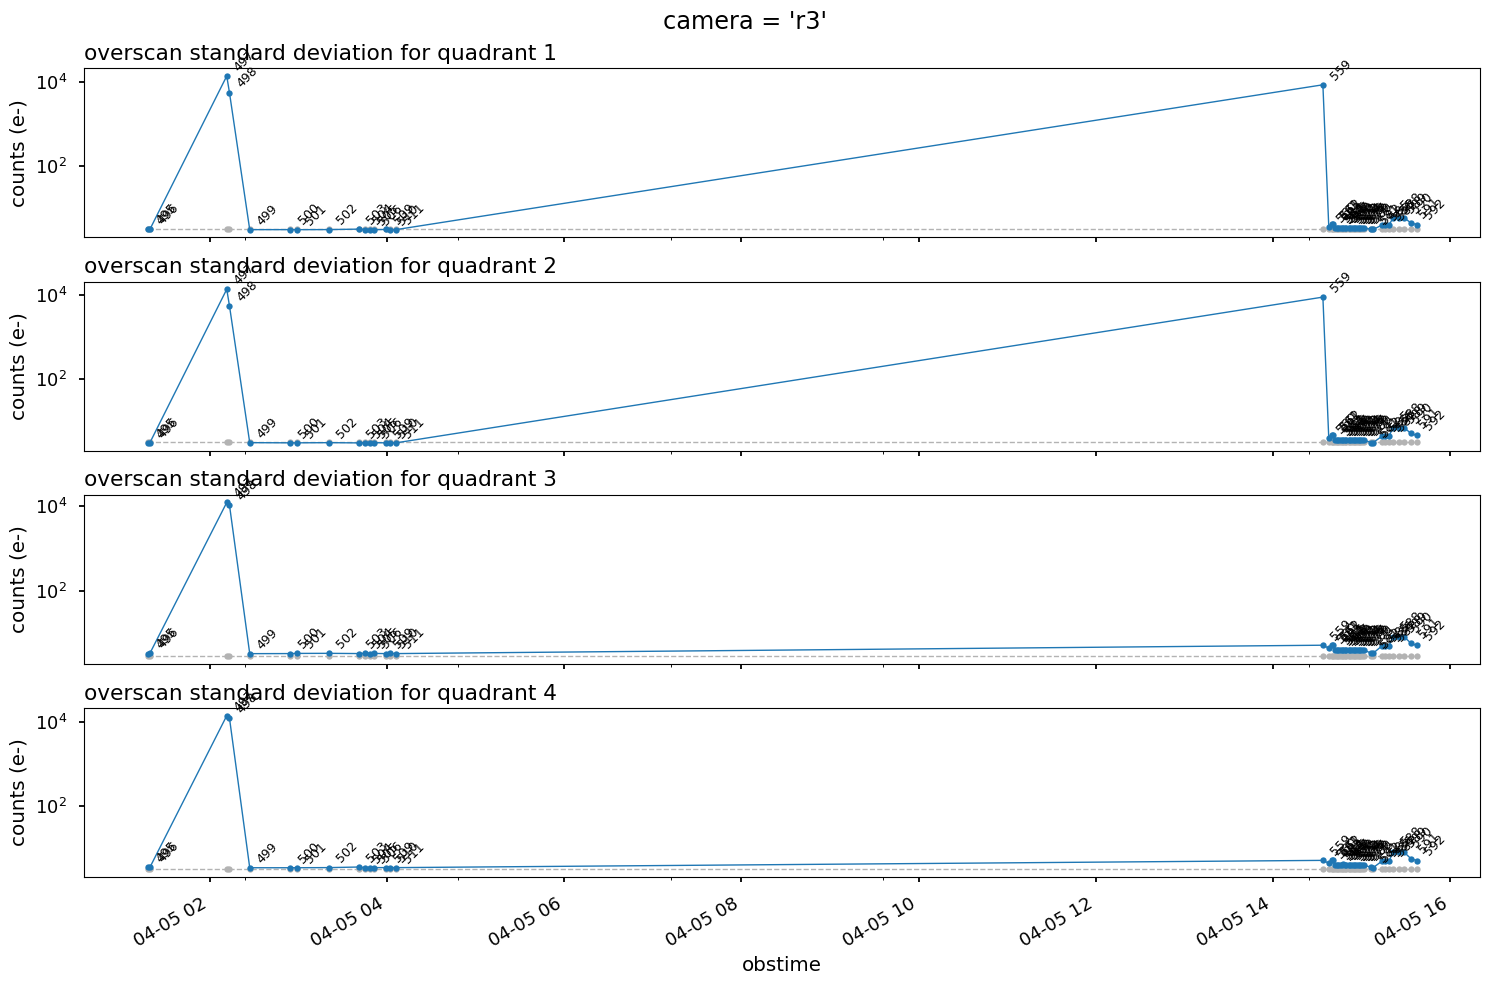

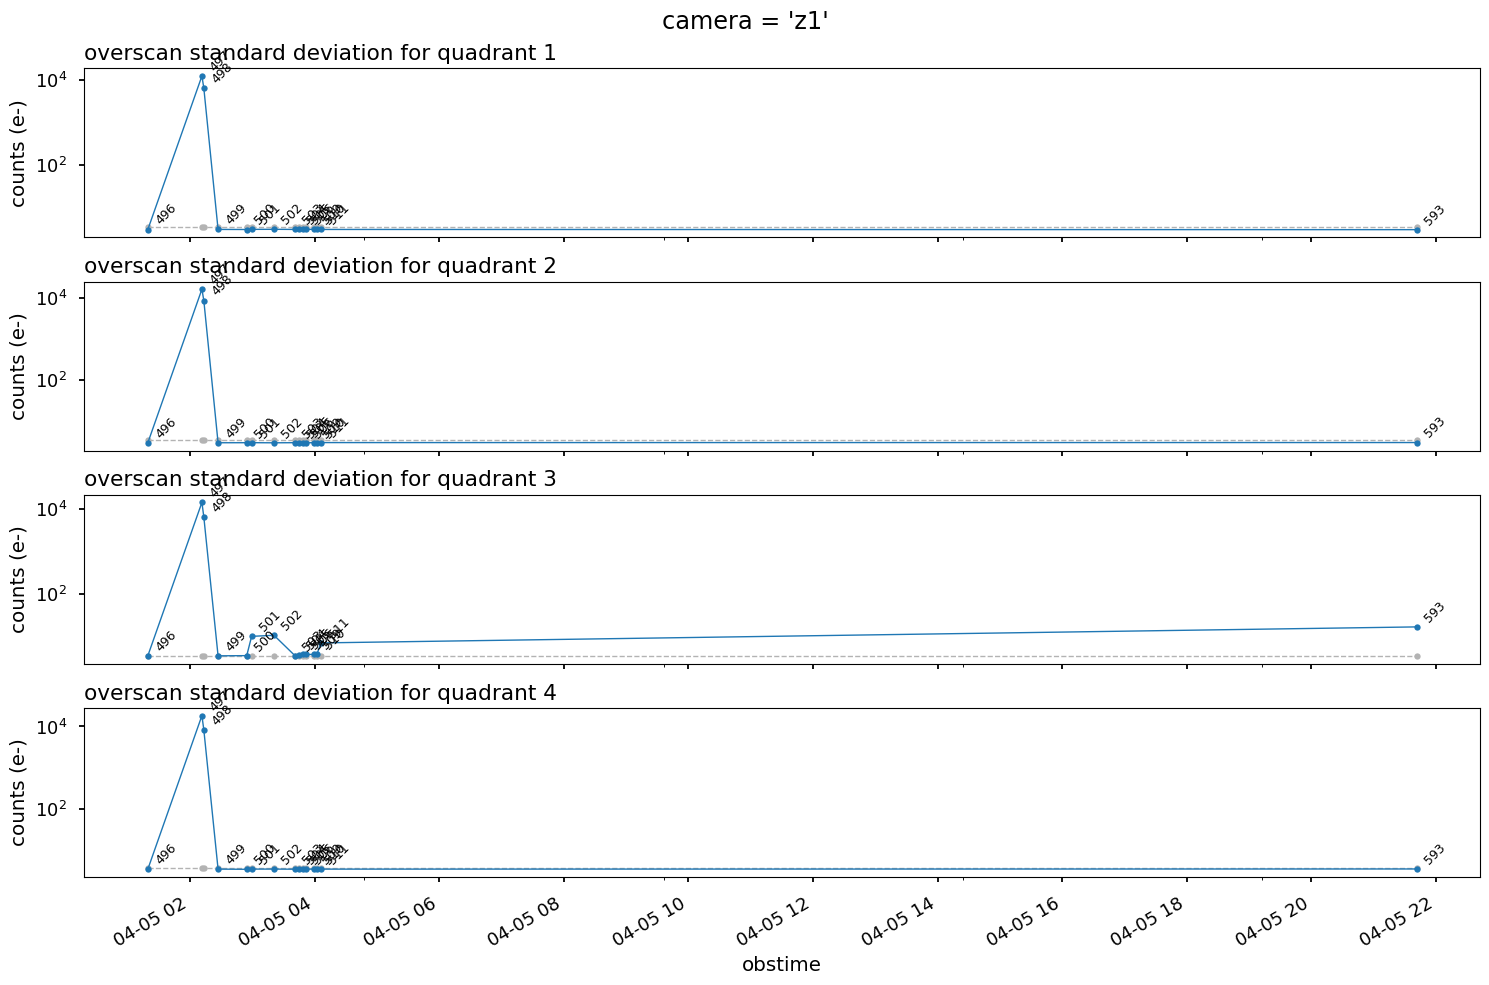

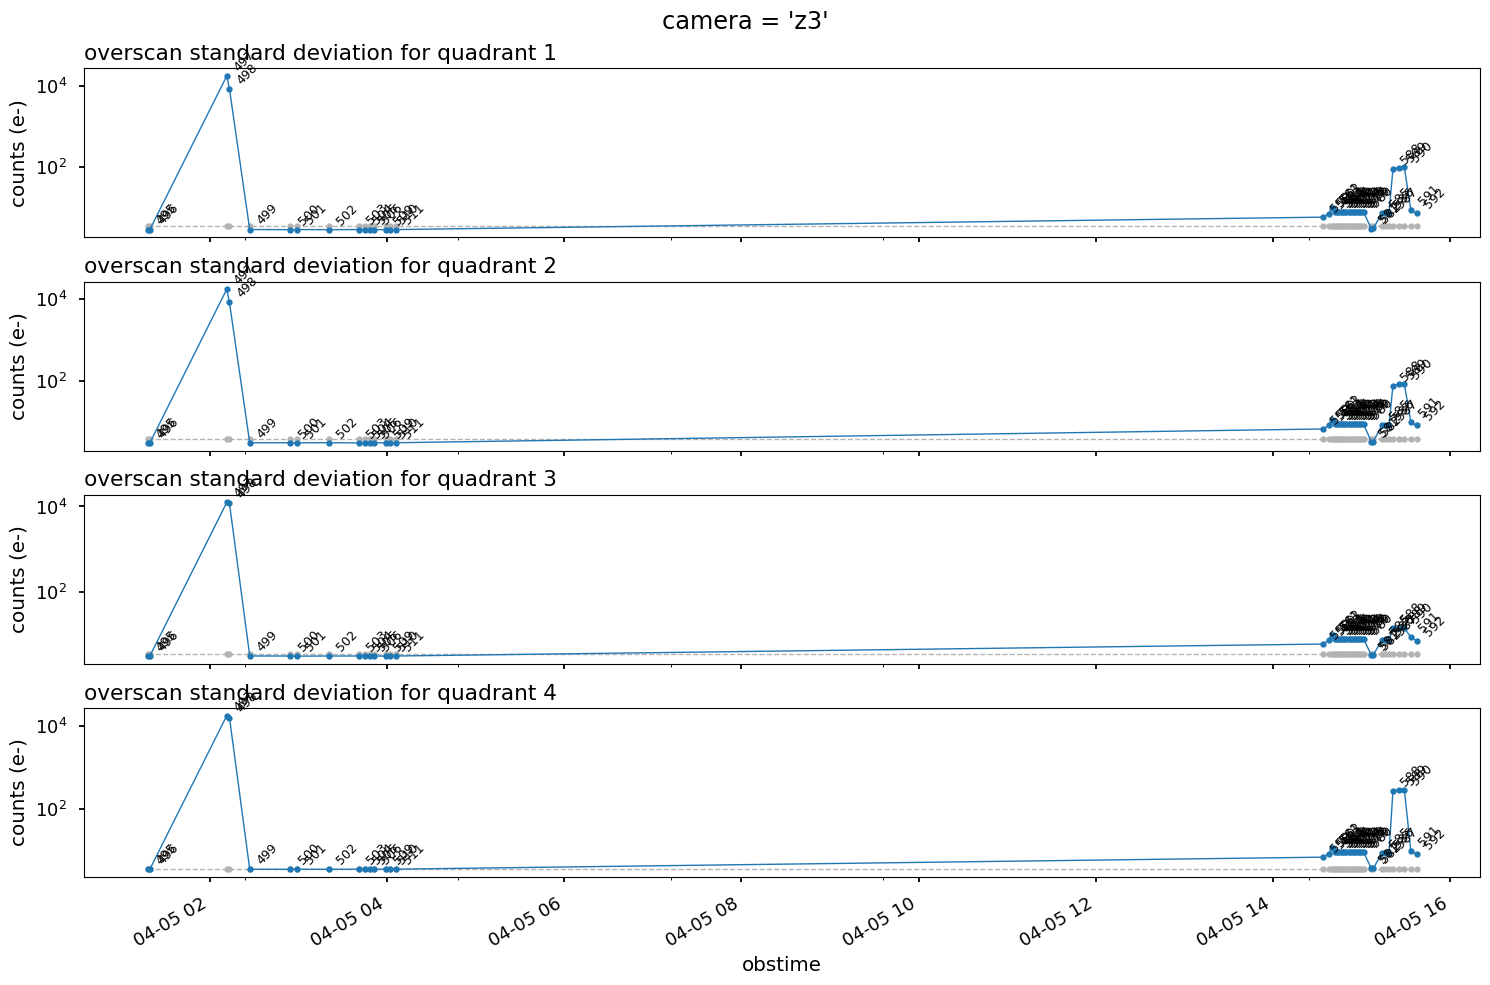

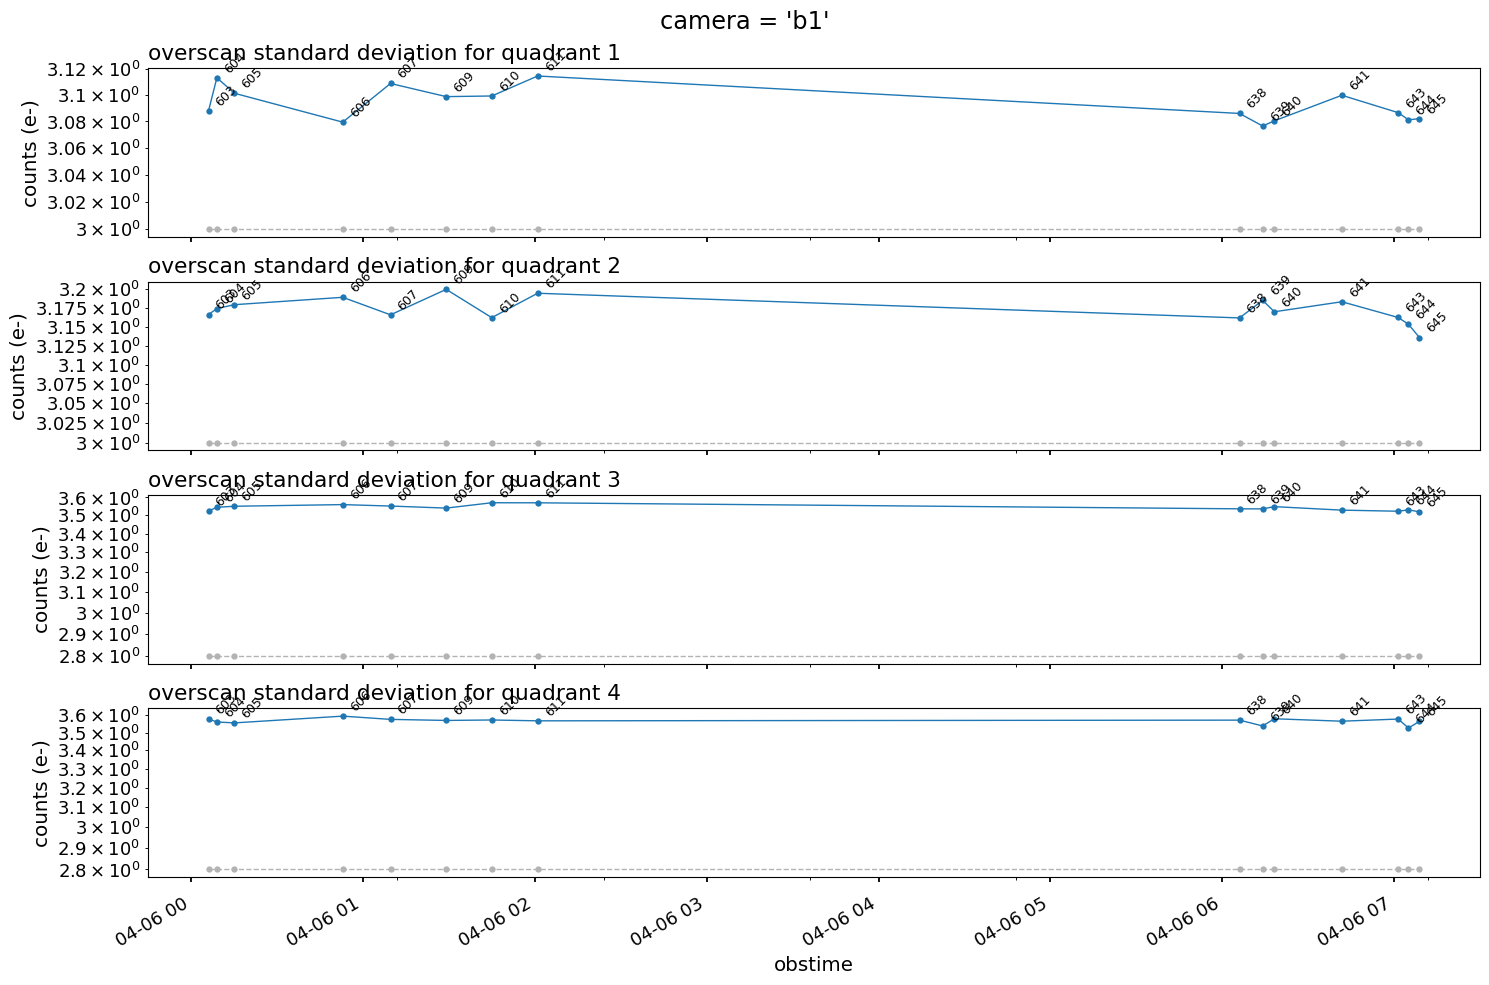

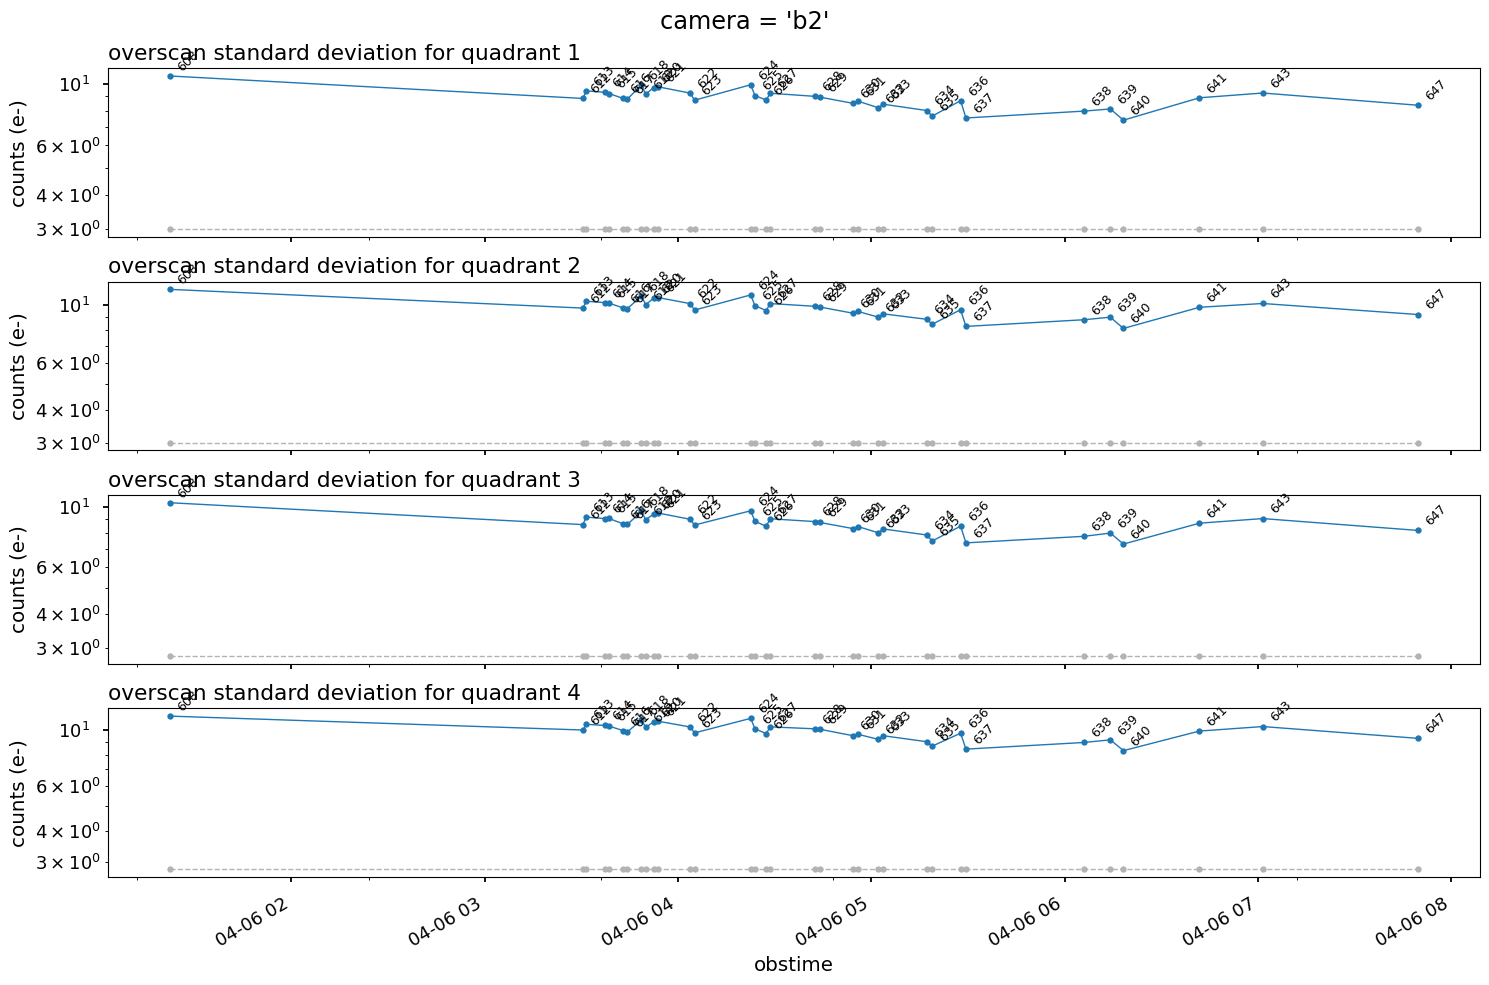

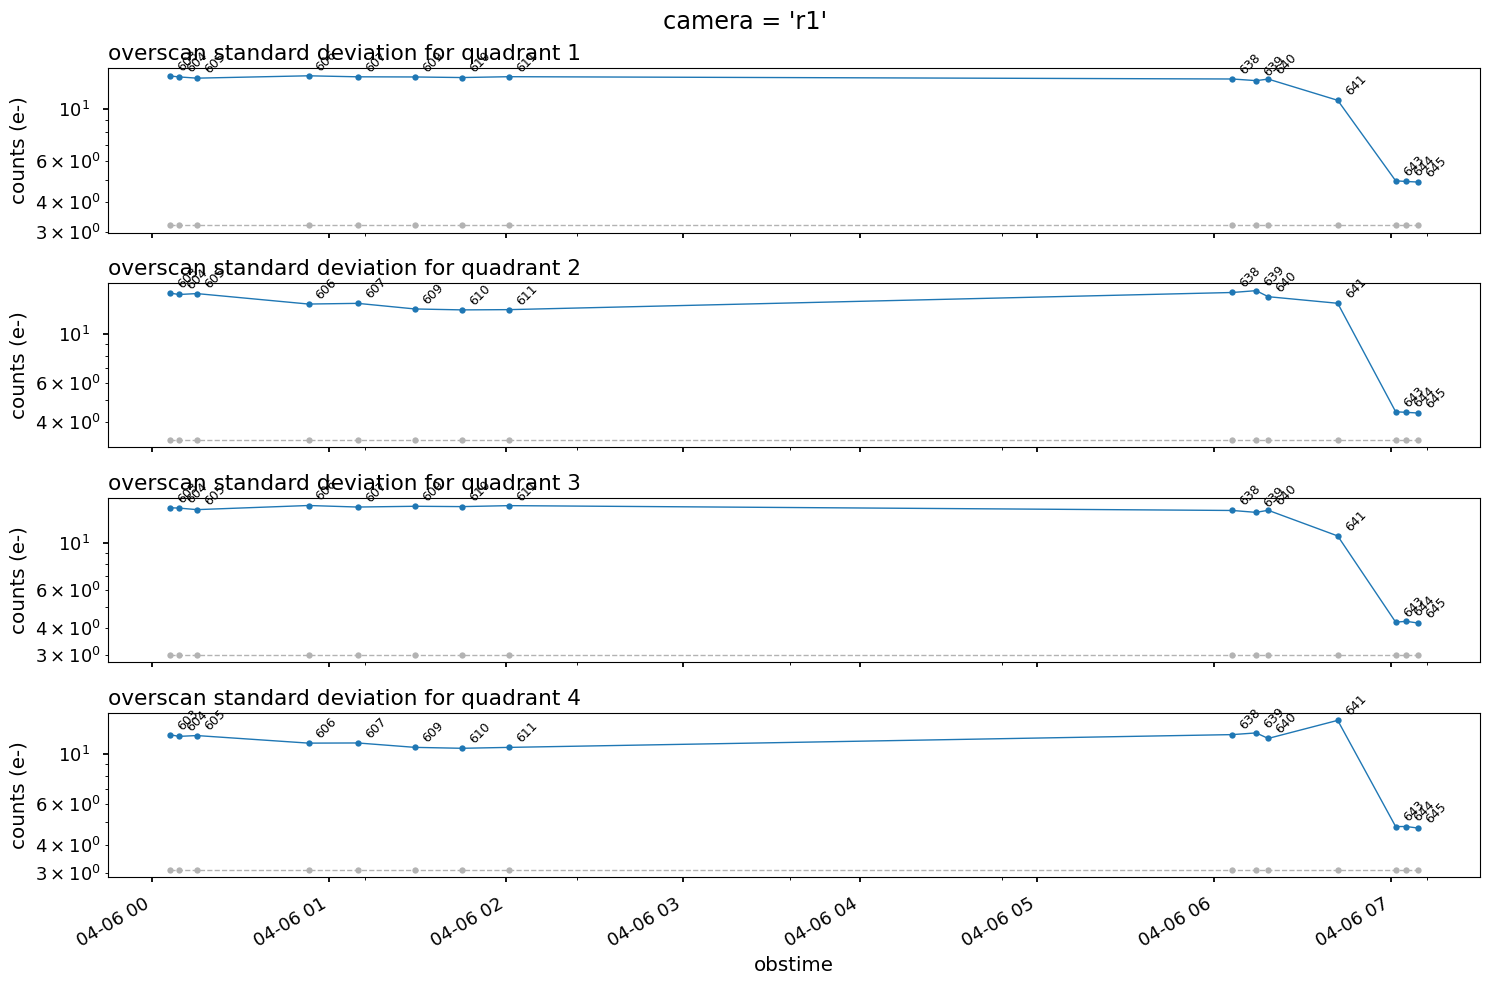

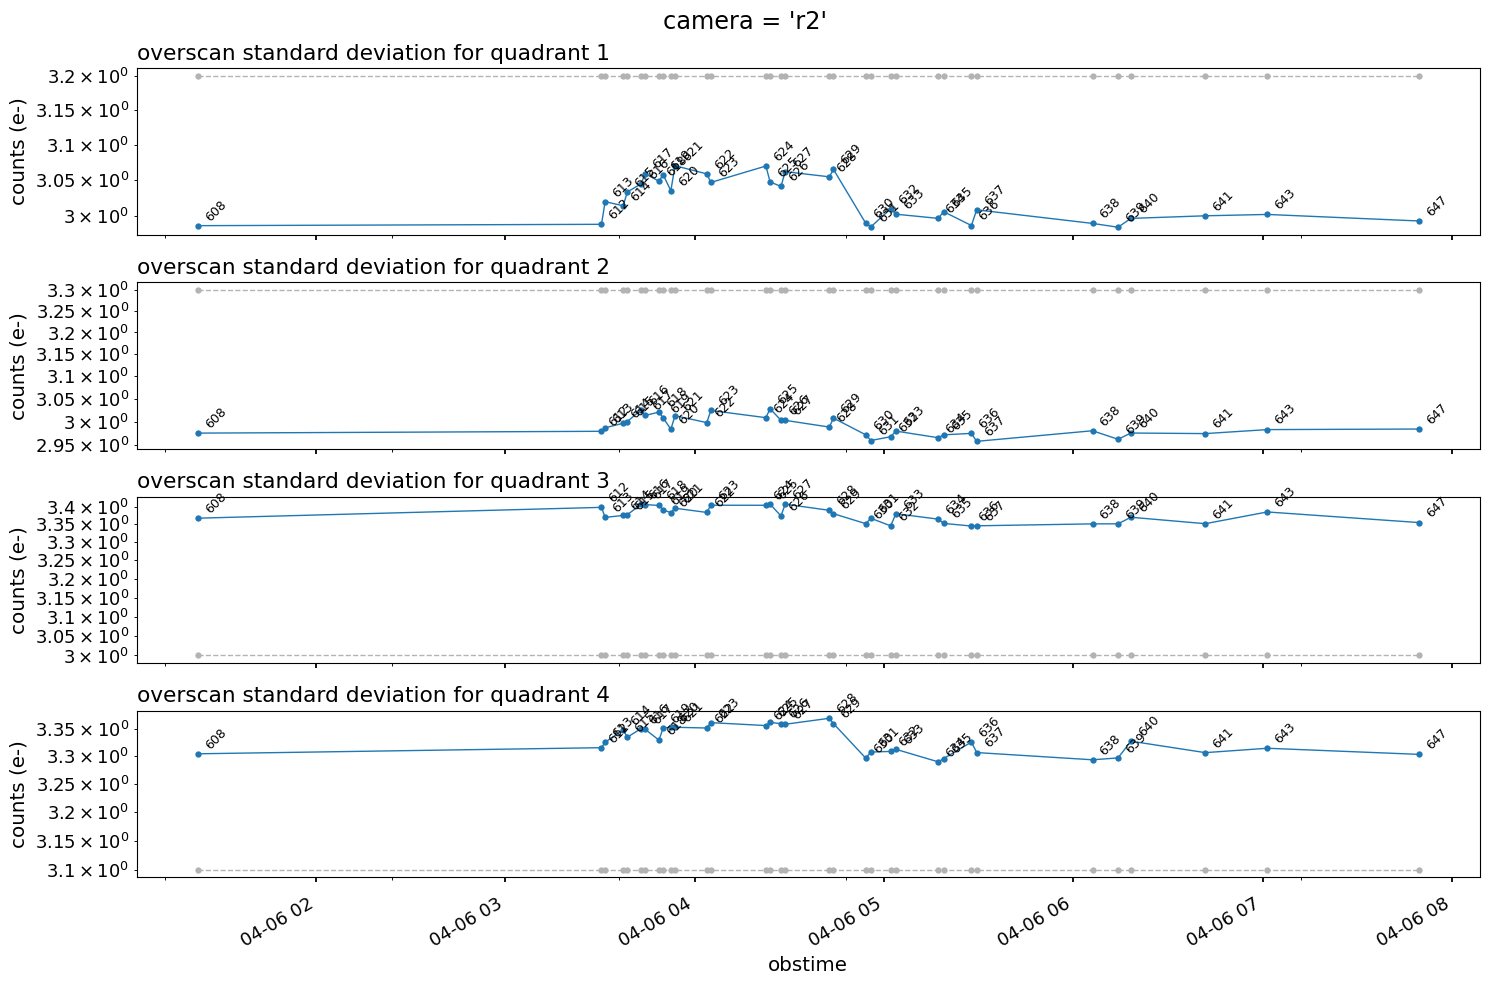

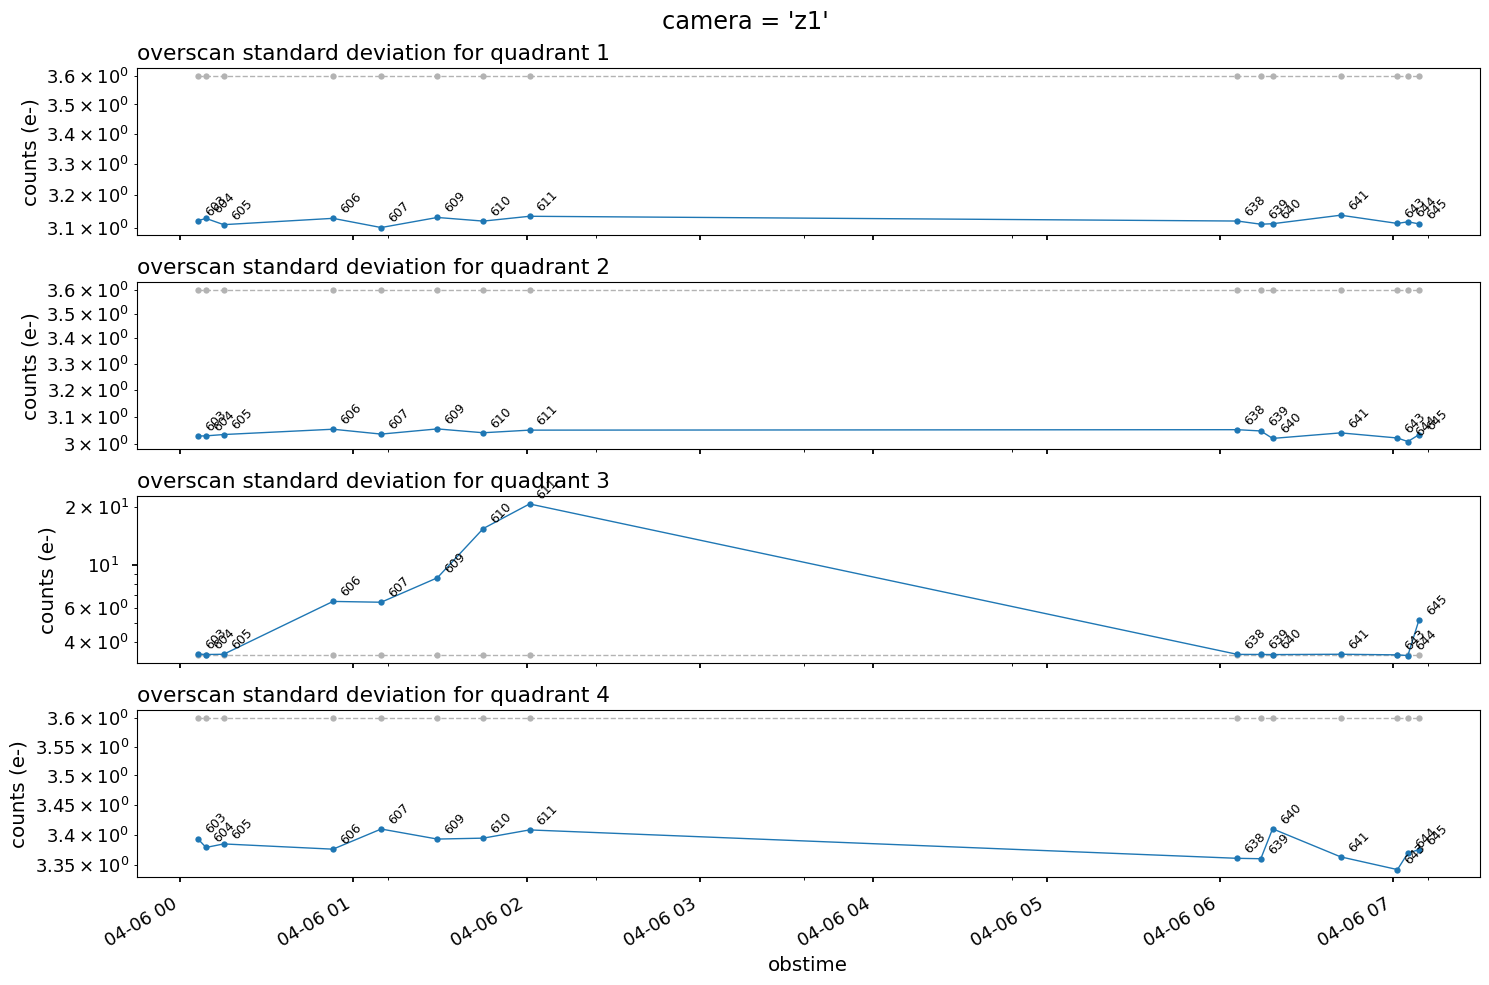

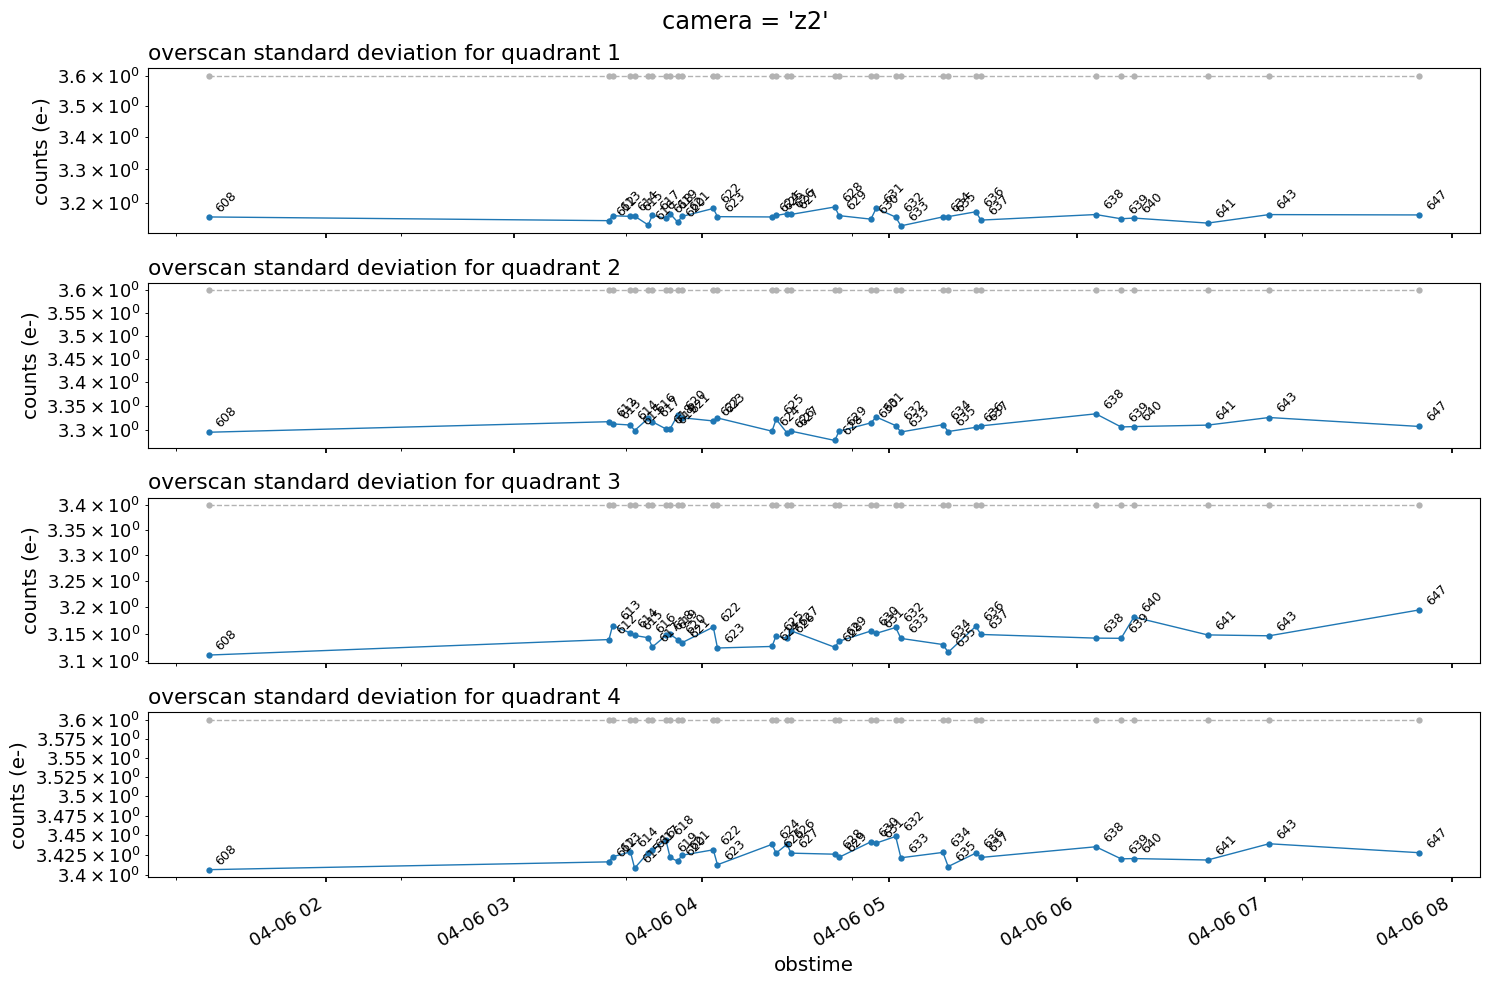

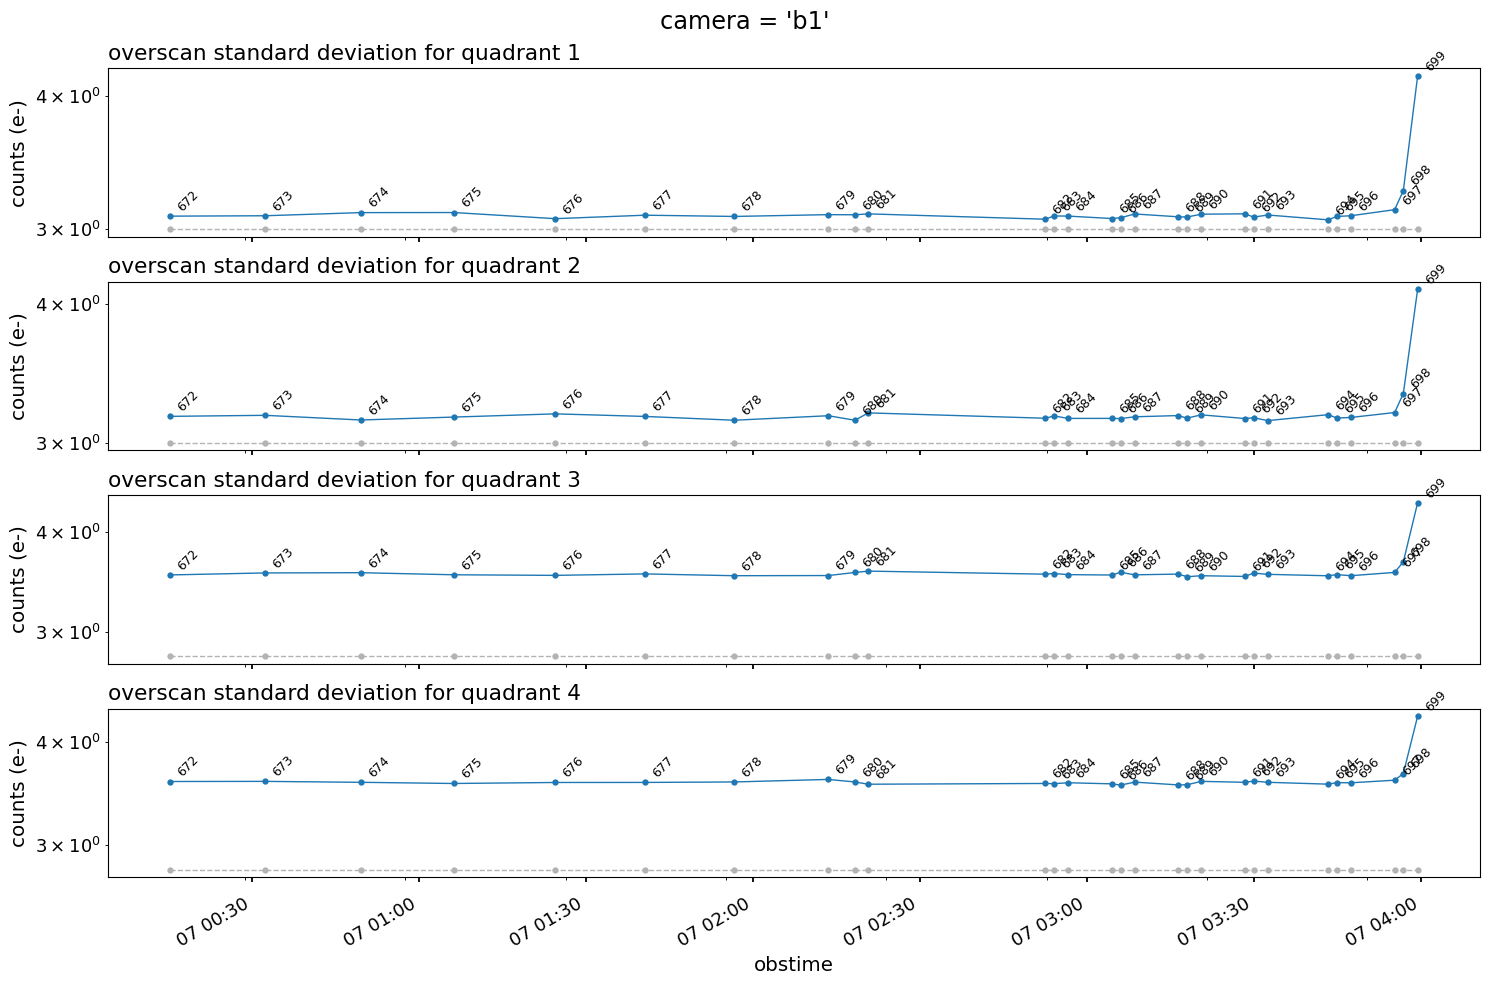

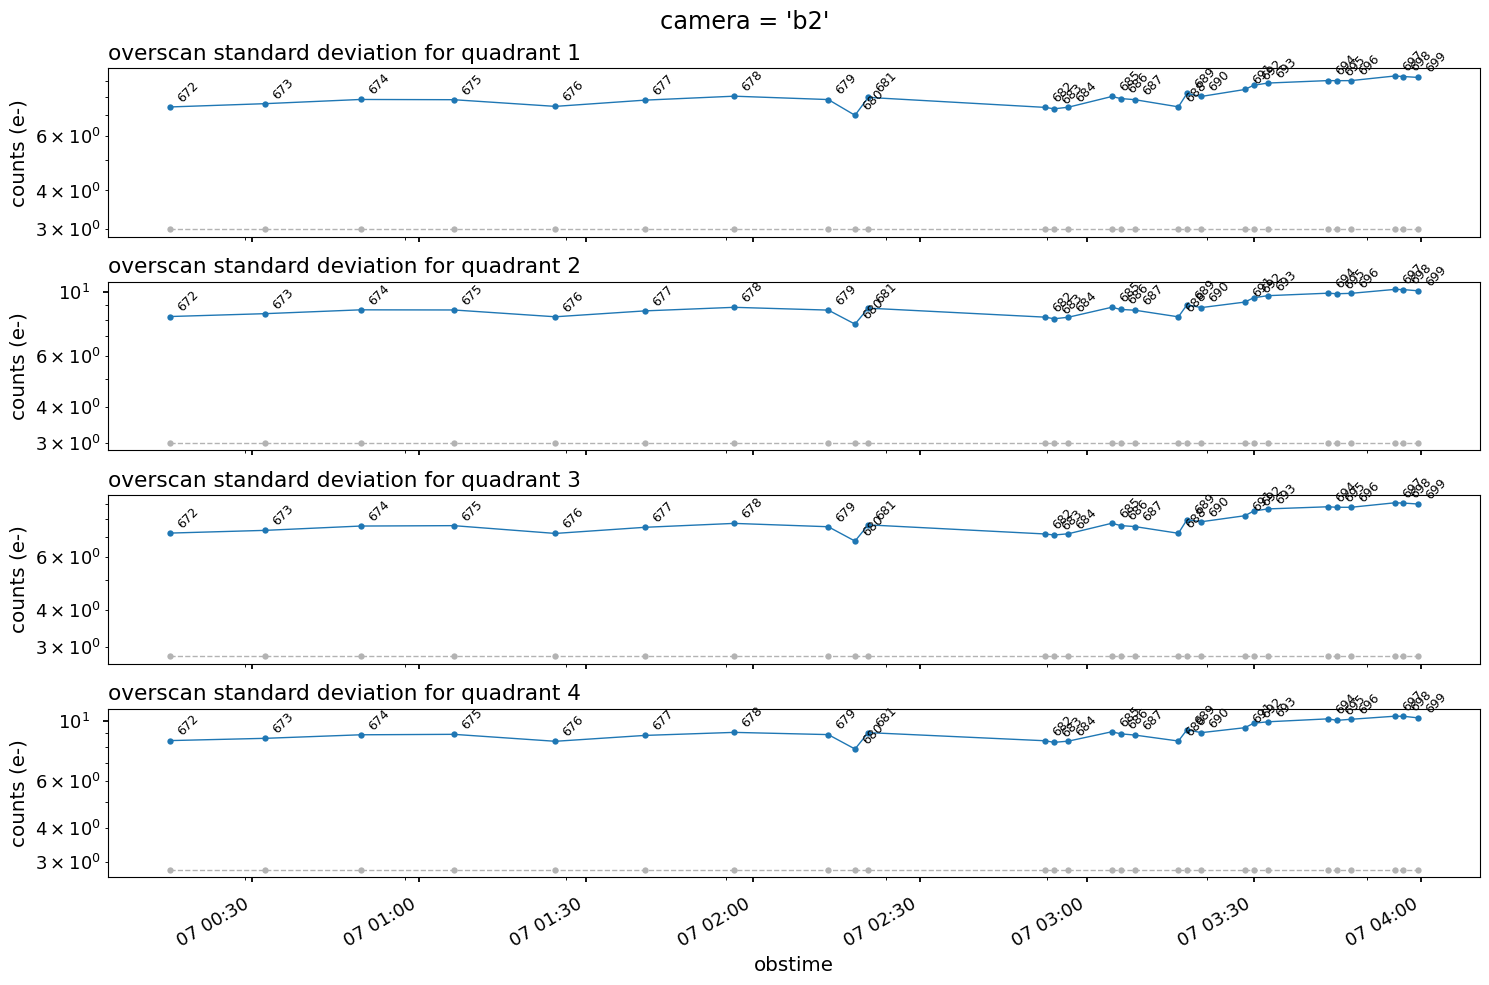

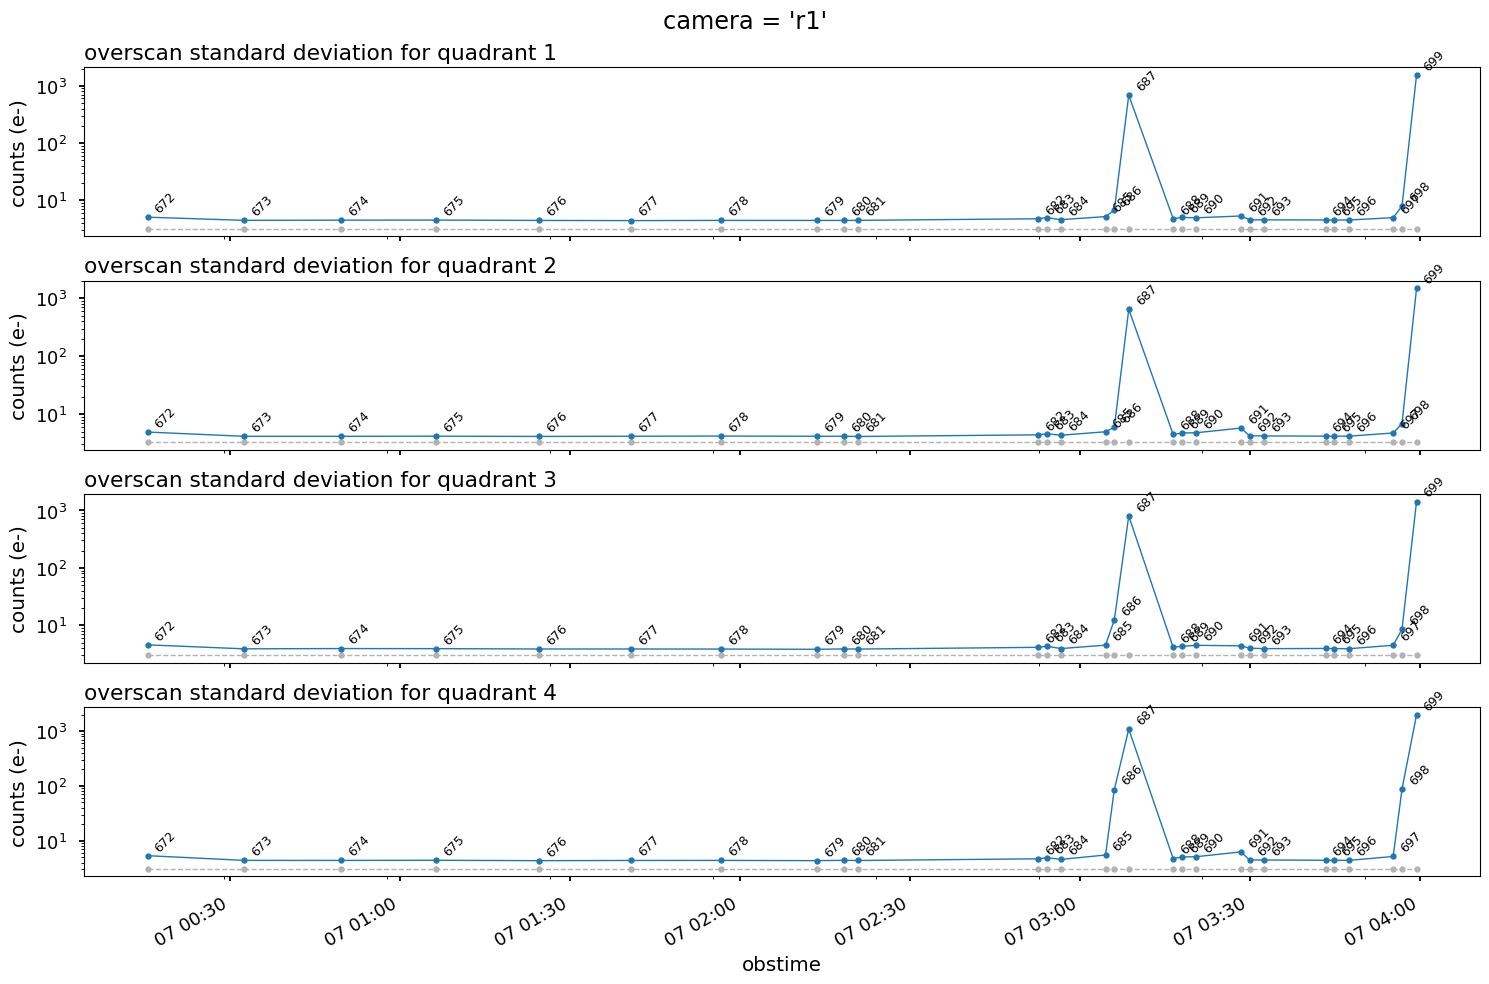

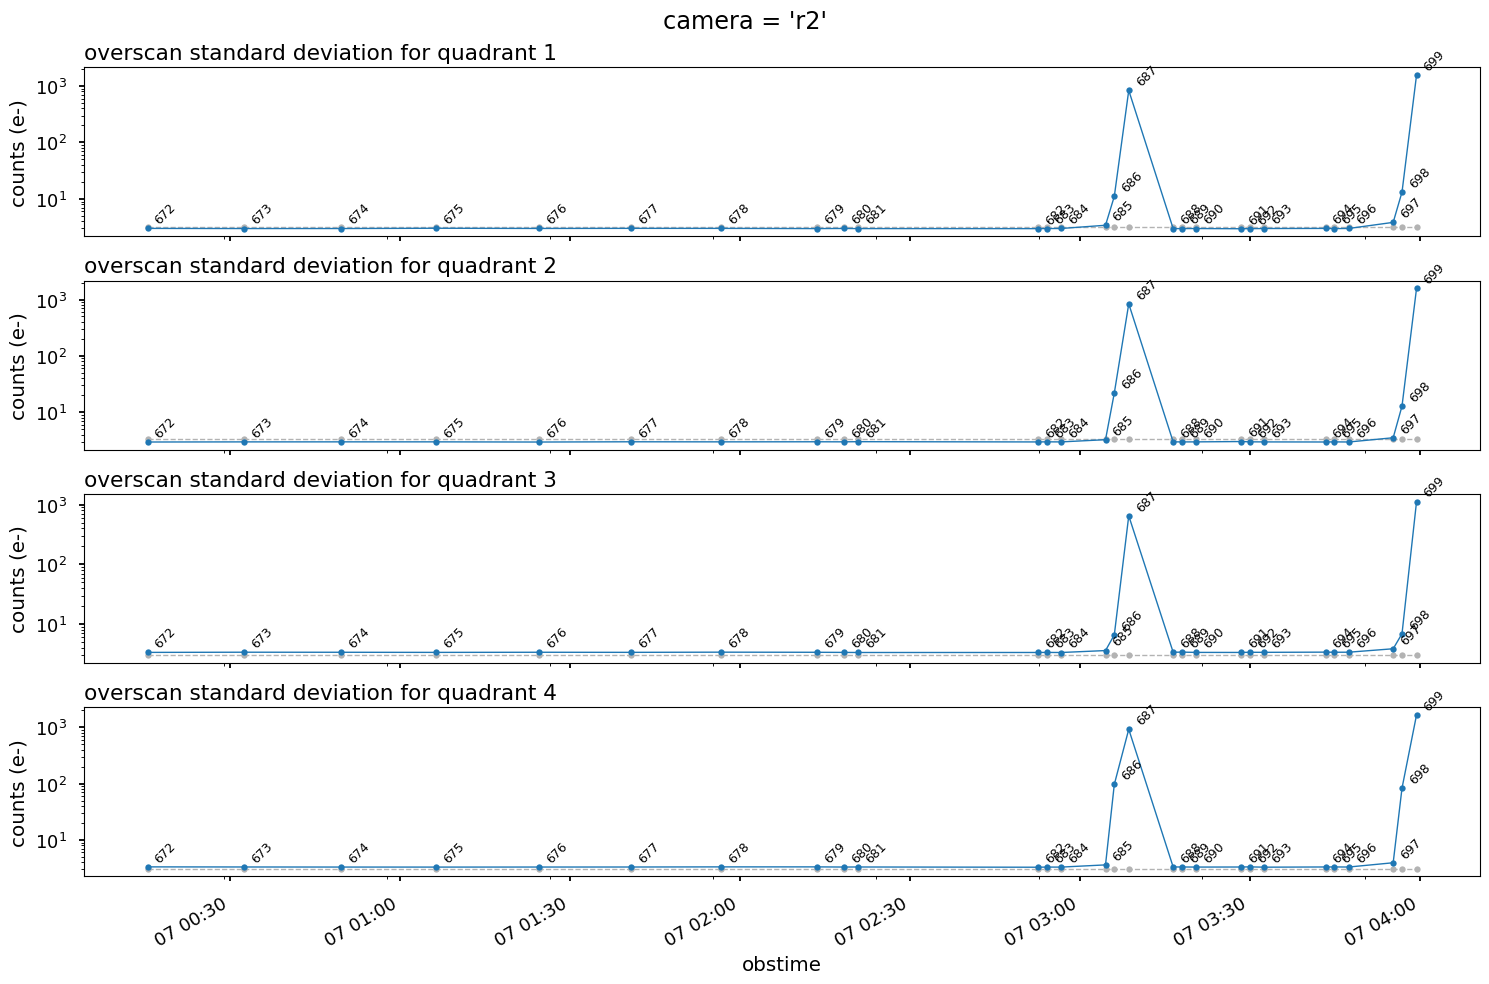

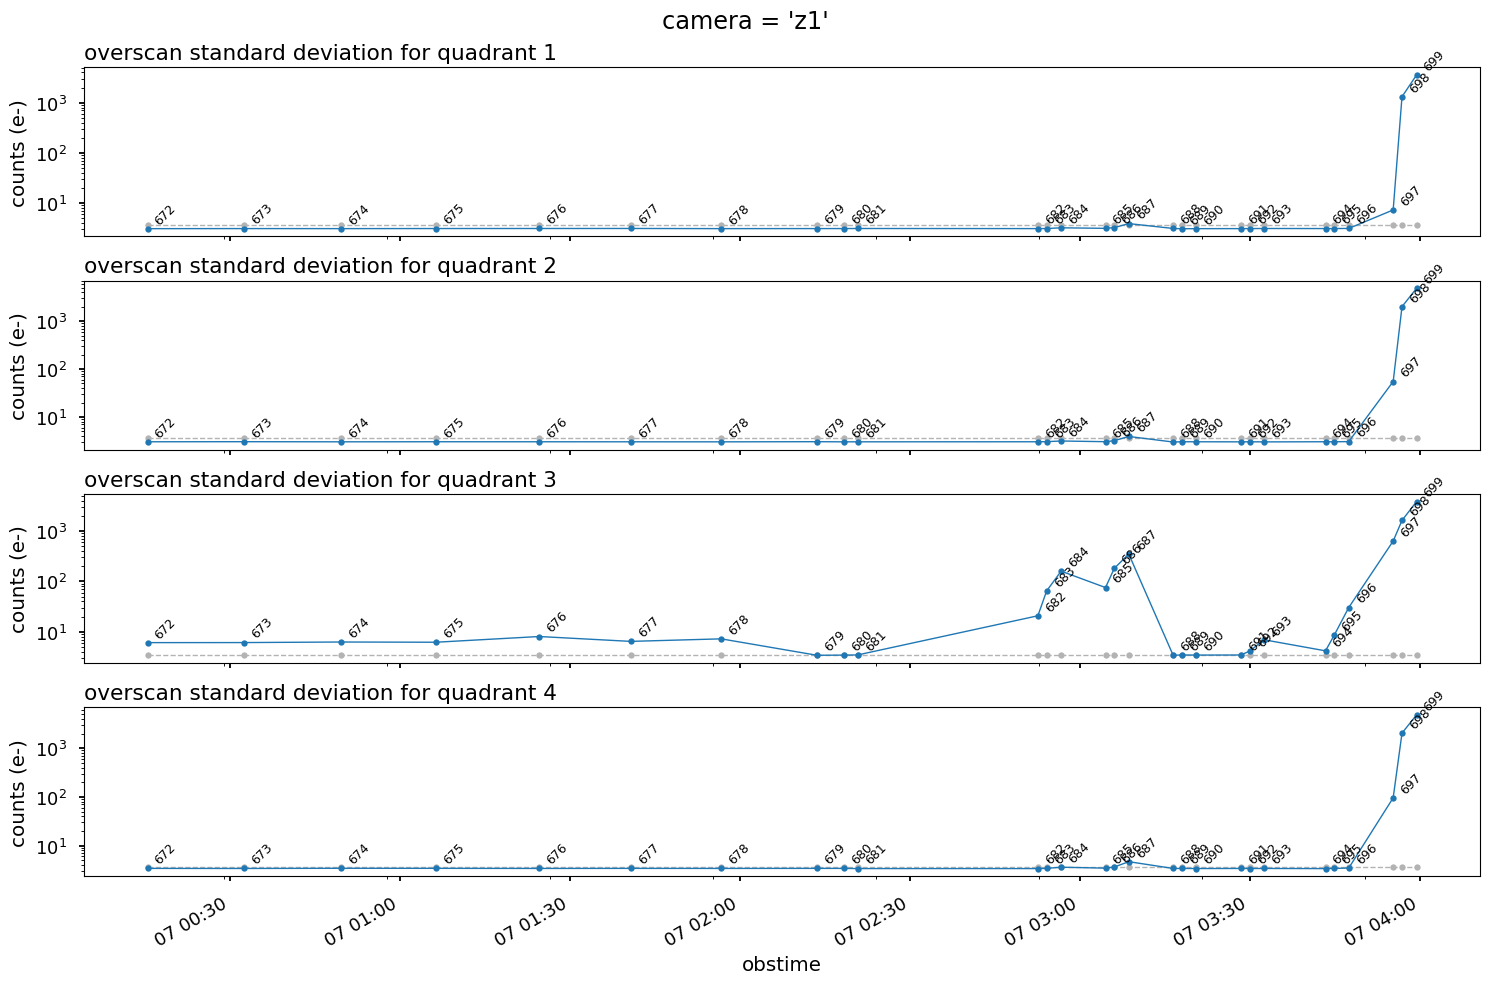

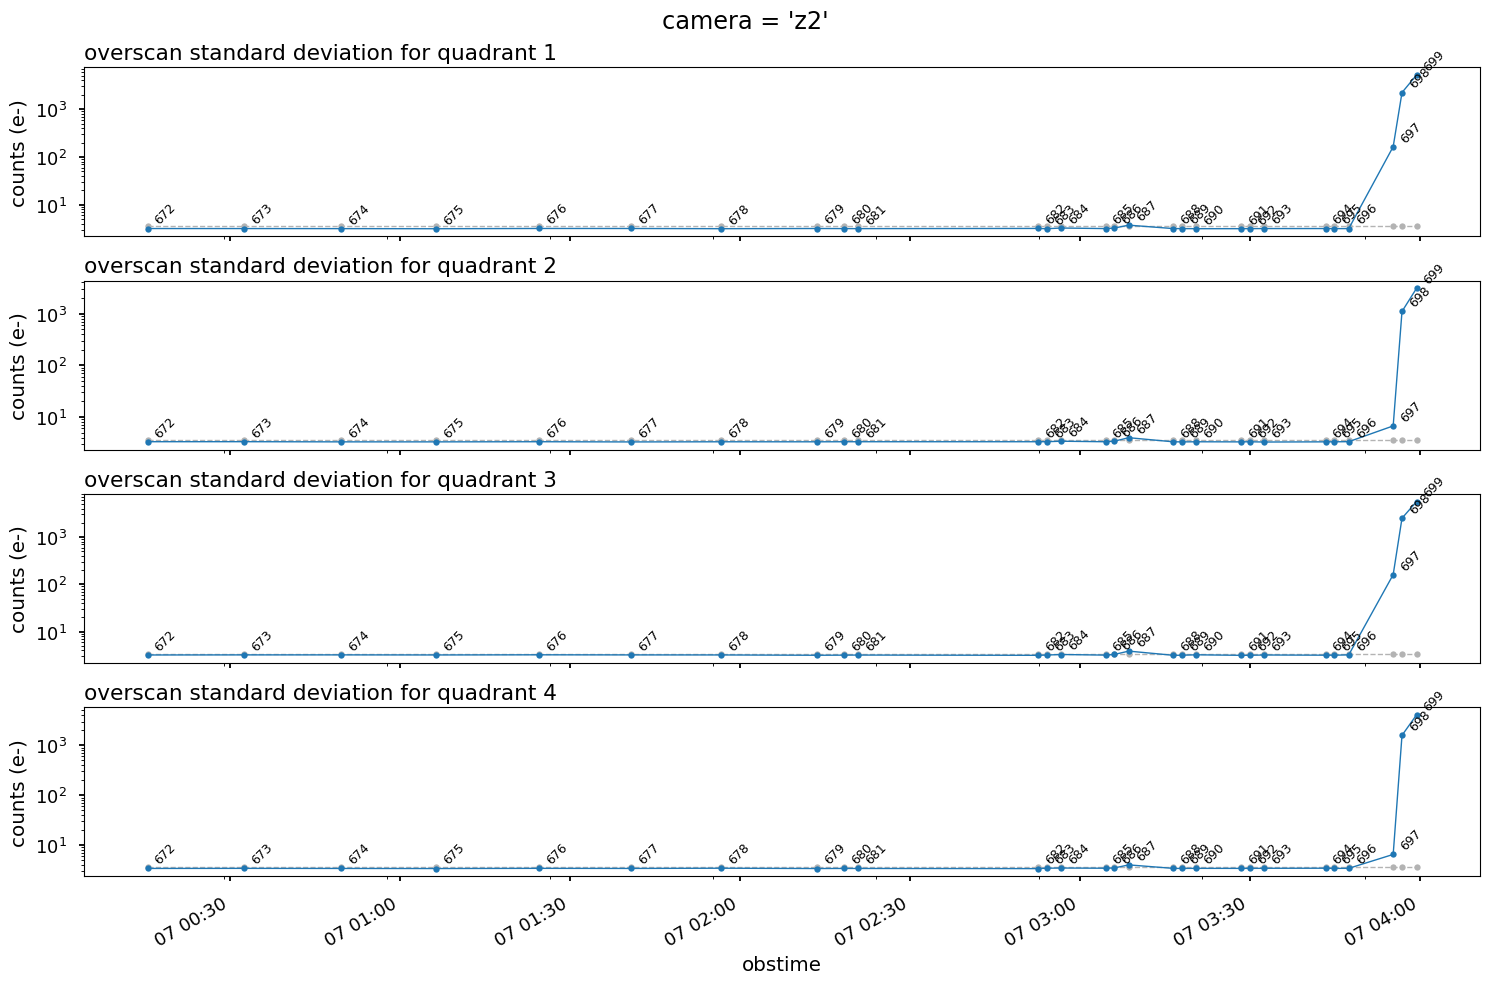

In [5]:
mjds = [60010, 60011, 60039, 60040, 60041]

for mjd in tqdm(mjds, desc="MJD", unit="mjd"):
    frame_groups = target_frames.loc[target_frames.mjd==mjd].groupby("camera")

    for camera in tqdm(frame_groups.groups, desc="camera", unit="camera"):
        frames_camera = frame_groups.get_group(camera).sort_values("mjd")
        table = pd.DataFrame(index=frames_camera.index, columns=[
            "frame",
            "exposure",
            "obstime",
            "exptime",
            "cnt_med1",
            "cnt_med2",
            "cnt_med3",
            "cnt_med4",
            "cnt_std1",
            "cnt_std2",
            "cnt_std3",
            "cnt_std4",
            "rdnoise1",
            "rdnoise2",
            "rdnoise3",
            "rdnoise4",
        ])
        for i, frame in tqdm(frames_camera.iterrows(), total=len(frames_camera), desc="frame", unit="frame"):
            img = image.loadImage(frame.path)

            # extract header metadata
            frame_name = img._header["FILENAME"].replace(".fits.gz", "")
            table.loc[i, "frame"] = frame_name
            table.loc[i, "exposure"] = img._header["EXPOSURE"]
            table.loc[i, "obstime"] = img._header["OBSTIME"]
            table.loc[i, "exptime"] = img._header["EXPTIME"]

            # prepare overscan strip plots
            fig_strips, axs_strips = plt.subplots(4, 1, figsize=(15,10), sharex=True, sharey=False)
            fig_strips.suptitle(f"{frame_name = }", size="xx-large")
            
            # compute statistics & plot quadrant strips
            for j in range(4):
                quad = img.getSection(imageMethod.DEFAULT_BIASSEC[j])
                quad *= img._header[f"GAIN{j+1}"]
                table.loc[i, f"cnt_med{j+1}"] = np.median(quad._data)
                table.loc[i, f"cnt_std{j+1}"] = np.std(quad._data)
                table.loc[i, f"rdnoise{j+1}"] = img._header[f"RDNOISE{j+1}"]
                # table.loc[i, f"cnt_std{j+1}"] = mad(quad._data, axis=None)

                # plot strip
                axs_strips[j].axhline(table.loc[i, f"cnt_med{j+1}"], ls="-", lw=1, color="0.2")
                axs_strips[j].axhline(table.loc[i, f"cnt_med{j+1}"]+img._header[f"RDNOISE{j+1}"], ls="--", lw=1, color="0.2")
                # axs_strips[j].axhspan(
                #     table.loc[i, f"cnt_med{j+1}"]-table.loc[i, f"cnt_std{j+1}"],
                #     table.loc[i, f"cnt_med{j+1}"]+table.loc[i, f"cnt_std{j+1}"],
                #     lw=0, hatch="///", fc="none", ec="0.2"
                # )
                plot_strips(quad, axis=1, nstrip=1, ax=axs_strips[j])
                
                axs_strips[j].set_ylabel("counts (e-)")
                axs_strips[j].set_title(f"overscan strips for quadrant {j+1}", loc="left")

            # save strips figure
            axs_strips[-1].set_xlabel("Y (pixel)")
            fig_strips.tight_layout()
            fig_strips.savefig(f"qa_overscan/{mjd}-{frame_name}_os.png", bbox_inches="tight")
            plt.close(fig=fig_strips)

        # further processing of timeseries
        table.obstime = pd.to_datetime(table.obstime)
        table.set_index("obstime", inplace=True)
        table.sort_index(inplace=True)
        print(table.to_string())

        # prepare overscan timeseries plot
        fig_ts, axs_ts = plt.subplots(4, 1, figsize=(15,10), sharex=True, sharey=False)
        fig_ts.suptitle(f"{camera = }", size="xx-large")

        # plot overscan timeseries
        for i in range(4):
            column = f"cnt_std{i+1}"
            table[f"rdnoise{i+1}"].plot(kind="line", ax=axs_ts[i], style=".--", lw=1, color="0.7")
            table[column].plot(kind="line", ax=axs_ts[i], style=".-", lw=1, color="tab:blue")

            axs_ts[i].set_yscale("log")
            axs_ts[i].set_ylabel("counts (e-)")
            axs_ts[i].set_title(f"overscan standard deviation for quadrant {i+1}", loc="left")

            for x, row in table.iterrows():
                axs_ts[i].annotate(row.exposure, (x, row[column]), xytext=(5, 5), textcoords="offset pixels", rotation=45, size=9)

        fig_ts.tight_layout()
        fig_ts.savefig(f"qa_overscan/{mjd}-{camera}_os.pdf", bbox_inches="tight")
        # plt.close(fig=fig_ts)